In [512]:
import pyomo.environ as pyo
import pyomo.gdp as gdp
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

In [513]:
# training_points = multivariate_normal.rvs(size=(10,2))
# training_points =  np.array(
#     [[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 1.0], 
#     [1.0, 0.5], [0.5, 1.0],
#     [1.0, 0.25], [0.25, 1.0],
#     [0.25, 0.0], [0.25, 0.0], [0.25, 0.5],
#     [0.0, 0.5], [0.5, 0.0], [0.5, 0.5]]
# )
training_points = np.array(
    [[0.0, 0.0], [2.0, 0.0], [0.0, 2.0], [2.0, 2.0]]
)
# df = pd.DataFrame(training_points)
# df.to_csv('training_points_causing_problem.csv')

# df = pd.read_csv("training_points_causing_problem.csv") 
# training_points = df.values[:,1:]

In [514]:
training_points

array([[0., 0.],
       [2., 0.],
       [0., 2.],
       [2., 2.]])

In [515]:

class RarePatternDetect:
    def __init__(self, training_set: np.array, min_area: float):
        self.training_set = training_set # a N x d matrix
        self.min_area = min_area # the smallest allowed area
        self.N, self.d = self.training_set.shape
        self.Nrange, self.drange = (range(x) for x in self.training_set.shape)
        self.largest_bounding_area = np.array(
            [
                [
                    np.min(self.training_set[:,0]),
                    np.min(self.training_set[:,1])
                ], 
                [
                    np.max(self.training_set[:,0]),
                    np.max(self.training_set[:,1])
                ]
            ]
        )
        self.model = self.create_model()
           
    
    def create_model(self):
        def _pattern_area():
            return pyo.prod(model.interval_lengths[i] for i in self.drange)

        # define model
        model = pyo.ConcreteModel()

        ## variables
        # x is a 2d vector
        # model.d_dimension = pyo.Set(initialize=self.drange)
        # model.d_dimension = pyo.Set(initialize=self.drange)
        # model.matrix = pyo.Set(initialize=(model.d_dimension * model.d_dimension)) # range(2))

        model.d_dimension = pyo.Set(initialize=self.drange)
        model.matrix = pyo.Set(initialize=model.d_dimension * model.d_dimension)
        def adjust_largest_pattern_bounds(model, i, j): 
            min_b = np.min(self.training_set[:,i])
            max_b = np.max(self.training_set[:,i])
            return min_b, max_b

        model.pattern = pyo.Var(model.matrix , bounds=adjust_largest_pattern_bounds)

        # TODO: simplify with np.apply_along_axis
        # def _adjust_largest_pattern_bounds(model, i, j):
            # print("i,j: ",i,j)
            # if (i, j) == (0, 0):
            #     min_b = np.min(self.training_set[i, :])
            #     max_b = np.max(self.training_set[i, :])
            # elif (i, j) == (0, 1):
            #     min_b = np.min(self.training_set[i, :])
            #     max_b = np.max(self.training_set[i, :])
            # elif (i, j) == (1, 0):
            #     min_b = np.min(self.training_set[j, :])
            #     max_b = np.max(self.training_set[j, :])
            # else:  # (1,1)
            #     min_b = np.min(self.training_set[j, :])
            #     max_b = np.max(self.training_set[j, :])
            # return (min_b, max_b)
        # model.pattern = pyo.Var(model.matrix, bounds=_adjust_largest_pattern_bounds)

        def adjust_pattern_bounds(model, i, j): 
            min_b = np.min(self.training_set[:,i])
            max_b = np.max(self.training_set[:,i])
            return min_b, max_b

        model.pattern = pyo.Var(model.matrix , bounds=adjust_pattern_bounds)

        # y is a boolean vector of size N
        model.included = pyo.Var(
            self.Nrange, within=pyo.Binary, initialize=0
        )

        # auxiliary variables
        model.interval_lengths = pyo.Var(
            self.drange, within=pyo.NonNegativeReals
        )
        model.point_left_of_pattern = pyo.Var(
            self.Nrange, self.drange, within=pyo.Binary, initialize=0
        )
        model.point_right_of_pattern = pyo.Var(
            self.Nrange, self.drange, within=pyo.Binary, initialize=0
        )
        
        ## objective (minimised by default)
        model.obj = pyo.Objective(
            expr=sum(model.included[i] for i in self.Nrange)/_pattern_area(), 
            sense=pyo.minimize
        )

        ## constraints

        # pattern area needs to exceed min_area
        model.area_constraint = pyo.Constraint(
            expr=_pattern_area() >= self.min_area
        )

        # training points included in model.included lie within the pattern (NB: In principle we would need to ensure that points not included are also
        # not included in model.included. However, since including points outside the pattern increases the objective, this is covered.)

        model.include_constraint = pyo.ConstraintList()
        model.enforce_point_left_of_pattern = pyo.ConstraintList()
        model.enforce_point_right_of_pattern = pyo.ConstraintList()
        M = 100000
        for j in self.Nrange:
            for i in self.drange:
                # print("i: ",i)
                # enforcing auxiliary variables are correct: point_left_of_pattern[j,i] is True iff the jth training point lies strictly outside the pattern in ith dimension, etc.
                model.enforce_point_left_of_pattern.add(
                    (model.point_left_of_pattern[j, i]*M + self.training_set[j,i]) >=  model.pattern[0,i]
                )
                model.enforce_point_left_of_pattern.add(
                     self.training_set[j,i] + 1e-3 <=  (model.pattern[0,i] + (1-model.point_left_of_pattern[j, i])*M)
                )
                model.enforce_point_right_of_pattern.add(
                   self.training_set[j,i] <=  (model.pattern[1,i] + model.point_right_of_pattern[j, i]*M)
                )
                model.enforce_point_right_of_pattern.add(
                    ((1-model.point_right_of_pattern[j, i])*M + self.training_set[j,i]) >=  (model.pattern[1,i] + 1e-3)
                )

            model.include_constraint.add(
                # key bit: this constraint enforces that the model.included for jth point can be set to 0 only if the point is not contained in the pattern (as witnessed by the fact
                # that the corresponding auxiliary variables are all 0)
                model.included[j] + sum(model.point_right_of_pattern[j,i] + model.point_left_of_pattern[j,i] for i in self.drange)  >= 1
            )

        # connect auxiliary variables: interval lengths are differences of pattern points
        model.interval_constraint = pyo.ConstraintList()
        for i in self.drange:
            model.interval_constraint.add(
                model.interval_lengths[i] == model.pattern[1,i] - model.pattern[0,i]
            )
        print("model.interval_lengths: ", model.interval_lengths)
        return model

    def add_point_to_model(self, point):
        # point to be classified lies in pattern
        point = point.squeeze()
        assert point.shape == (2,)
        self.model.point_constraint = pyo.ConstraintList()
        for i in self.drange:
            # x[i] <= point[i] <= x[i + d], for all i
            self.model.point_constraint.add(self.model.pattern[0, i] <= point[i])
            self.model.point_constraint.add(point[i] <= self.model.pattern[1, i])

    def extract_points_included_in_pattern(self):
        included_points = []
        for i in self.model.included:
            if np.round(self.model.included[i].value,1) == 1.0:
                # print("included point index: ",i, self.training_set[i])
                included_points.append(self.training_set[i])
        return np.array(included_points)

    def extract_pattern(self):
        intervals = np.zeros((2,2), dtype=float)
        for _, j in enumerate(self.model.pattern):
            # print("pattern coordinate value: ", j, self.model.pattern[j].value)
            intervals[j] = self.model.pattern[j].value
        return intervals.T

    def classify(self, point_to_be_classified: np.array):
        self.add_point_to_model(point_to_be_classified) # point to be classified is a 1 x d array
        _ = pyo.SolverFactory('mindtpy').solve(self.model, strategy='OA', mip_solver='glpk', nlp_solver='ipopt', tee=True,)
        # self.model.display()
        return pyo.value(self.model.obj)

In [516]:
rare_pattern_detect = RarePatternDetect(training_points, min_area=0.0)
point_to_be_classified = np.array([1.0,1.0])
#point_to_be_classified = training_points[1]
print("training_points[1]: ", training_points[1])
print("point_to_be_classified: ", point_to_be_classified)
results = rare_pattern_detect.classify(point_to_be_classified)
intervals = rare_pattern_detect.extract_pattern()
largest_bounding_area = rare_pattern_detect.largest_bounding_area
included_points = rare_pattern_detect.extract_points_included_in_pattern()

    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 43 constraints (1 nonlinear) and 0 disjunctions, with 26 variables, of which 20 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



model.interval_lengths:  interval_lengths
training_points[1]:  [2. 0.]
point_to_be_classified:  [1. 1.]


         -       Relaxed NLP      -2.89244e-08            inf   -2.89244e-08      nan%      1.90
         1              MILP      -4.96305e-09            inf   -4.96305e-09      nan%      1.95
*        1         Fixed NLP       -7.4941e-09    -7.4941e-09   -4.96305e-09    33.33%      2.10
MindtPy exiting on bound convergence. |Primal Bound: -7.494096404532882e-09 - Dual Bound: -4.96305172979809e-09| <= (absolute tolerance 0.0001)  

 Primal integral          :    0.0000 
 Dual integral            :    0.0000 
 Primal-dual gap integral :    0.0000 


In [517]:
print(results, largest_bounding_area)

0.0 [[0. 0.]
 [2. 2.]]


In [518]:
rare_pattern_detect.model.display()

Model unknown

  Variables:
    pattern : Size=4, Index=matrix
        Key    : Lower : Value                 : Upper : Fixed : Stale : Domain
        (0, 0) :   0.0 :    0.5003768528203754 :   2.0 : False : False :  Reals
        (0, 1) :   0.0 : 6.159611577351187e-10 :   2.0 : False : False :  Reals
        (1, 0) :   0.0 :    1.4996231471796246 :   2.0 : False : False :  Reals
        (1, 1) :   0.0 :    1.4620754507666087 :   2.0 : False : False :  Reals
    included : Size=4, Index=included_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   0.0 :     1 : False : False : Binary
          1 :     0 :   0.0 :     1 : False : False : Binary
          2 :     0 :   0.0 :     1 : False : False : Binary
          3 :     0 :   0.0 :     1 : False : False : Binary
    interval_lengths : Size=2, Index=interval_lengths_index
        Key : Lower : Value              : Upper : Fixed : Stale : Domain
          0 :     0 : 0.9992462943592493 :  None : Fal

In [519]:
# from io import StringIO 

# textbuffer = StringIO()
# for v in rare_pattern_detect.model.component_objects(pyo.Var):
#     v.pprint(textbuffer)
#     textbuffer.write('\n')

# for v in rare_pattern_detect.model.component_objects(pyo.Constraint):
#     v.pprint(textbuffer)
#     textbuffer.write('\n')

# for v in rare_pattern_detect.model.component_objects(pyo.Set):
#     v.pprint(textbuffer)
#     textbuffer.write('\n')


# with open('solver_log_2.txt', 'w') as outputfile:
#     outputfile.write(textbuffer.getvalue())

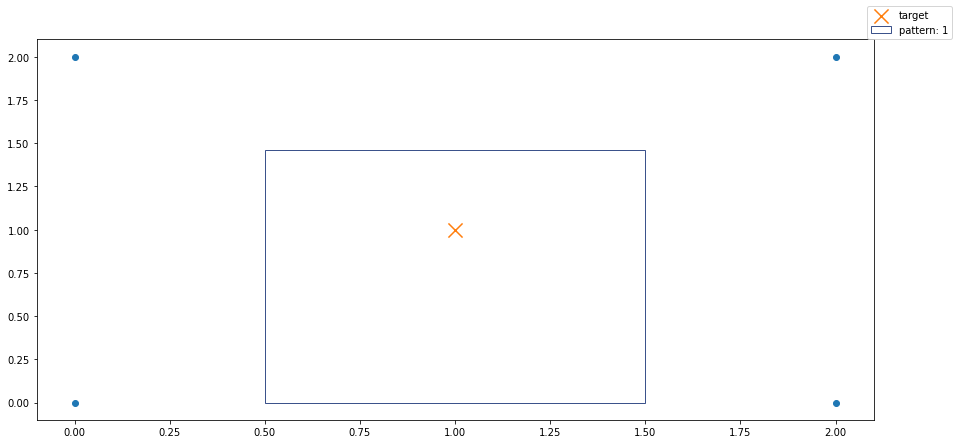

In [520]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,7)

cmap = plt.get_cmap('viridis')

def draw2dpattern(interval, ax, index, total):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(index/total),
        label=f"pattern: {index}"
        )
    )


plt.scatter(x=training_points[:,0], y=training_points[:,1])
plt.scatter(x=point_to_be_classified[0], y=point_to_be_classified[1], marker="x",  s=200, label="target") 
for i, p in enumerate(included_points):
    plt.scatter(x=p[0], y=p[1], marker="o", s=200, label=f"included point: {np.argwhere(training_points == p)[0,0]}")
ax = plt.gca()
draw2dpattern(intervals, ax, 1, len(training_points))
ax.legend(bbox_to_anchor=(1.1, 1.1))
plt.show()

In [521]:
# min x , min y 
# max x , max y
rare_pattern_detect.largest_bounding_area

array([[0., 0.],
       [2., 2.]])

In [526]:
from typing import Callable
import numpy as np
import json

class PACRPAD:
    """
    Superclass for all PAC-RPAD implementations
    """
    def __init__(self, tau, epsilon, delta):
        self.tau = tau
        self.epsilon = epsilon
        self.delta = delta
        self.find_min_f_hat = None

    def has_rare_pattern(self, point) -> bool:
        results = self.find_min_f_hat[f"{point}"]
        if results['objective'] != None:
            results['anomaly'] = results['objective'] <= self.tau + self.epsilon / 2
        return results['anomaly']


class AxisAlignedHyperRectanglePACRPAD(PACRPAD):
    def __init__(self, tau, epsilon, delta):
        super().__init__(tau, epsilon, delta)
        self.solver = None 
        self.training_points = None
        self.testing_points = None

    def construct_f_hat_estimator(self, training_points, testing_points, min_area=0.01):
        def _contains(point: np.ndarray, largest_bounding_area) -> bool:
            return all((largest_bounding_area[0,:] <= point.T) & (point.T <= largest_bounding_area[1,:]))

        self.training_points = training_points
        self.testing_points = testing_points
        dict_results = {}

        # Check if testing points lie within the initial pattern bounds
        dummy_solver = RarePatternDetect(self.training_points, min_area=min_area)
        candidates = []
        for idx, test_p in enumerate(self.testing_points):
            # TODO: extract the largest_bounding_area outside of the solver 
            # TODO: extract the functionalities of evaluating to has rare pattern 
            contained = _contains(test_p, dummy_solver.largest_bounding_area)
            if contained:
                # if yes then add testing_points to ensemble of points used to create the pattern space 
                candidates = [train_p for train_p in self.training_points]
                candidates = np.array(candidates)
                candidates = np.append(candidates, [test_p], axis=0)
                self.solver = RarePatternDetect(candidates, min_area=min_area)
                objective = self.solver.classify(test_p)
                intervals = self.solver.extract_pattern()
                included_points = self.solver.extract_points_included_in_pattern()
                dict_results[f"{test_p}"] =  {
                    'index' : idx,
                    'anomaly' : None,
                    'objective' : objective, 
                    'pattern' : intervals.tolist(), 
                    'included points' : included_points.tolist()
                }
            else:
                # else: anomaly = True
                dict_results[f"{test_p}"] =  {
                    'index' : idx,
                    'anomaly' : True,
                    'objective' : None, 
                    'pattern' : None, 
                    'included points' : None
                }

        with open('minlp_results.json', 'w') as fp:
            json.dump(dict_results, fp, indent=4)

        self.find_min_f_hat = dict_results

In [527]:
exact = AxisAlignedHyperRectanglePACRPAD(tau=0.3, epsilon=0.1, delta=0.1)

In [524]:
testing_points = multivariate_normal.rvs(size=(20,2))
testing_points

array([[-0.66742653,  0.5228086 ],
       [ 1.50989288, -0.44689704],
       [ 0.25223689, -0.51328082],
       [ 1.36453261,  0.37690866],
       [-0.10306201, -0.26737055],
       [ 2.35784457, -1.24598848],
       [ 0.13653059,  0.49019642],
       [ 1.09948757, -1.65095227],
       [-0.92544505,  1.29945599],
       [-0.32122683, -0.12239972],
       [ 0.73540519, -2.5322866 ],
       [ 0.74450917,  0.34939219],
       [-1.27837381,  0.51292283],
       [ 0.73273204,  0.1123416 ],
       [ 0.30477649,  0.1030289 ],
       [ 0.29805452,  0.68671944],
       [ 0.41160903, -0.35541169],
       [ 0.23385004,  0.5055801 ],
       [-0.8227077 , -0.38375457],
       [-0.5795784 , -1.58527616]])

In [530]:
exact.construct_f_hat_estimator(training_points, testing_points, min_area=0.5)
labels_pac_minlp = [exact.has_rare_pattern(x) for x in exact.testing_points]
labels_pac_minlp

    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
model.interval_lengths:  interval_lengths
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 52 constraints (1 nonlinear) and 0 disjunctions, with 31 variables, of which 25 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



model.interval_lengths:  interval_lengths


         -       Relaxed NLP       -2.4503e-08            inf    -2.4503e-08      nan%      0.20
         1              MILP          0.590768            inf       0.590768      nan%      0.24
*        1         Fixed NLP          0.250375       0.250375       0.590768   135.95%      0.36
         2              MILP          0.590768       0.250375       0.590768   135.95%      0.40
Cycling happens after 2 main iterations. The same combination is obtained in iteration 1 This issue happens when the NLP subproblem violates constraint qualification. Convergence to optimal solution is not guaranteed.
Final bound values: Primal Bound: 0.25037544117365157  Dual Bound: 0.590768326684109
 Primal integral          :    0.0000 
 Dual integral            :    0.1177 
 Primal-dual gap integral :    0.1177 


    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 52 constraints (1 nonlinear) and 0 disjunctions, with 31 variables, of which 25 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



model.interval_lengths:  interval_lengths


         -       Relaxed NLP      -2.43831e-08            inf   -2.43831e-08      nan%      0.13
         1              MILP           0.58837            inf        0.58837      nan%      0.17
*        1         Fixed NLP          0.250375       0.250375        0.58837   135.00%      0.27
         2              MILP           0.58837       0.250375        0.58837   135.00%      0.30
*        2         Fixed NLP          0.250375       0.250375        0.58837   135.00%      0.39
         3              MILP           0.58837       0.250375        0.58837   135.00%      0.42
Cycling happens after 3 main iterations. The same combination is obtained in iteration 2 This issue happens when the NLP subproblem violates constraint qualification. Convergence to optimal solution is not guaranteed.
Final bound values: Primal Bound: 0.2503754411531066  Dual Bound: 0.588370216070469
 Primal integral          :    0.0000 
 Dual integral            :    0.0793 
 Primal-dual gap integral :    0.0793 

    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 52 constraints (1 nonlinear) and 0 disjunctions, with 31 variables, of which 25 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



model.interval_lengths:  interval_lengths


         -       Relaxed NLP      -1.46368e-08            inf   -1.46368e-08      nan%      0.13
         1              MILP          0.393444            inf       0.393444      nan%      0.17
*        1         Fixed NLP          0.250375       0.250375       0.393444    57.14%      0.28
         2              MILP          0.393444       0.250375       0.393444    57.14%      0.31
Cycling happens after 2 main iterations. The same combination is obtained in iteration 1 This issue happens when the NLP subproblem violates constraint qualification. Convergence to optimal solution is not guaranteed.
Final bound values: Primal Bound: 0.25037544117371036  Dual Bound: 0.393444036068671
 Primal integral          :    0.0000 
 Dual integral            :    0.0517 
 Primal-dual gap integral :    0.0517 


    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 52 constraints (1 nonlinear) and 0 disjunctions, with 31 variables, of which 25 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



model.interval_lengths:  interval_lengths


         -       Relaxed NLP      -6.08937e-08            inf   -6.08937e-08      nan%      0.17
         1              MILP           1.12697            inf        1.12697      nan%      0.21
*        1         Fixed NLP          0.250375       0.250375        1.12697   350.11%      0.31
         2              MILP           1.12697       0.250375        1.12697   350.11%      0.35
         2         Fixed NLP          0.250375       0.250375        1.12697   350.11%      0.44
         3              MILP           1.12697       0.250375        1.12697   350.11%      0.47
Cycling happens after 3 main iterations. The same combination is obtained in iteration 2 This issue happens when the NLP subproblem violates constraint qualification. Convergence to optimal solution is not guaranteed.
Final bound values: Primal Bound: 0.25037544112713506  Dual Bound: 1.12696591803642
 Primal integral          :    0.0000 
 Dual integral            :    0.1891 
 Primal-dual gap integral :    0.1891 

    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 52 constraints (1 nonlinear) and 0 disjunctions, with 31 variables, of which 25 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



model.interval_lengths:  interval_lengths


         -       Relaxed NLP      -3.31084e-08            inf   -3.31084e-08      nan%      0.13
         1              MILP          0.571259            inf       0.571259      nan%      0.17
*        1         Fixed NLP          0.250375       0.250375       0.571259   128.16%      0.27
         2              MILP          0.571259       0.250375       0.571259   128.16%      0.30
Cycling happens after 2 main iterations. The same combination is obtained in iteration 1 This issue happens when the NLP subproblem violates constraint qualification. Convergence to optimal solution is not guaranteed.
Final bound values: Primal Bound: 0.25037544116382243  Dual Bound: 0.571258522538427
 Primal integral          :    0.0000 
 Dual integral            :    0.0743 
 Primal-dual gap integral :    0.0743 


    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 52 constraints (1 nonlinear) and 0 disjunctions, with 31 variables, of which 25 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



model.interval_lengths:  interval_lengths


         -       Relaxed NLP       -1.1762e-08            inf    -1.1762e-08      nan%      0.13
         1              MILP          0.336559            inf       0.336559      nan%      0.17
*        1         Fixed NLP          0.250375       0.250375       0.336559    34.42%      0.28
         2              MILP          0.336559       0.250375       0.336559    34.42%      0.31
*        2         Fixed NLP          0.250375       0.250375       0.336559    34.42%      0.41
         3              MILP          0.336559       0.250375       0.336559    34.42%      0.45
Cycling happens after 3 main iterations. The same combination is obtained in iteration 2 This issue happens when the NLP subproblem violates constraint qualification. Convergence to optimal solution is not guaranteed.
Final bound values: Primal Bound: 0.25037544115882693  Dual Bound: 0.336558723218176
 Primal integral          :    0.0000 
 Dual integral            :    0.0440 
 Primal-dual gap integral :    0.0440

    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 52 constraints (1 nonlinear) and 0 disjunctions, with 31 variables, of which 25 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



model.interval_lengths:  interval_lengths


         -       Relaxed NLP       -1.5693e-08            inf    -1.5693e-08      nan%      0.16
         1              MILP          0.414569            inf       0.414569      nan%      0.20
*        1         Fixed NLP          0.250375       0.250375       0.414569    65.58%      0.33
         2              MILP          0.414569       0.250375       0.414569    65.58%      0.37
Cycling happens after 2 main iterations. The same combination is obtained in iteration 1 This issue happens when the NLP subproblem violates constraint qualification. Convergence to optimal solution is not guaranteed.
Final bound values: Primal Bound: 0.2503754411738148  Dual Bound: 0.414569345095799
 Primal integral          :    0.0000 
 Dual integral            :    0.0664 
 Primal-dual gap integral :    0.0664 


[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

pattern:  None


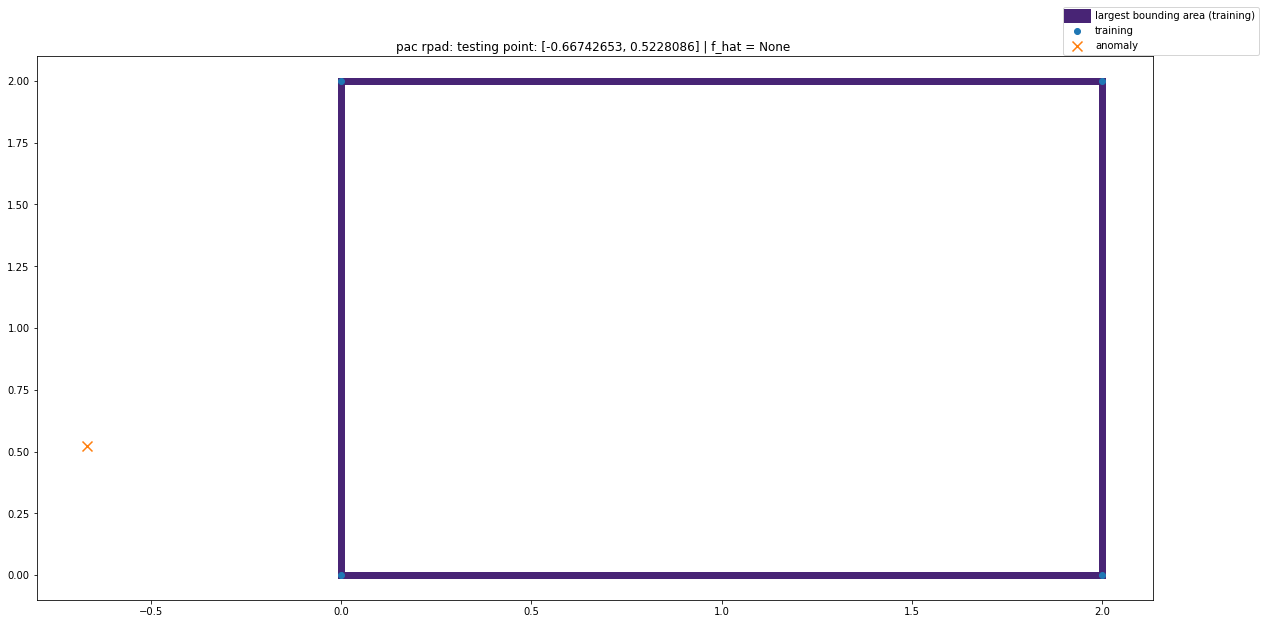

pattern:  None


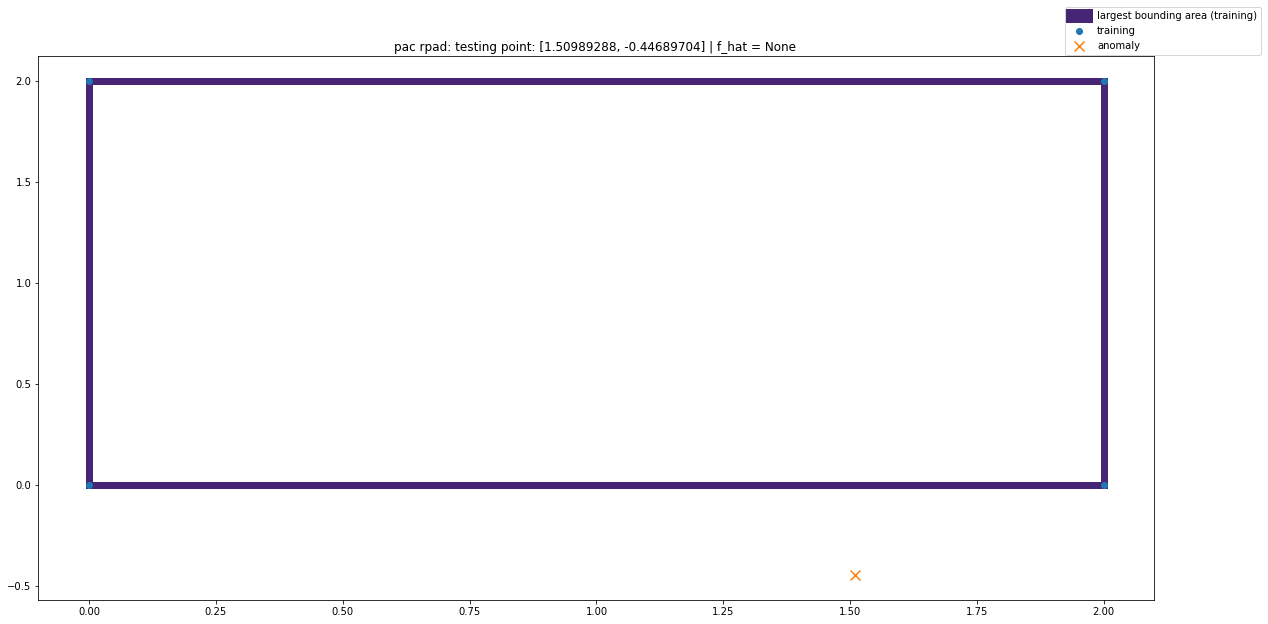

pattern:  None


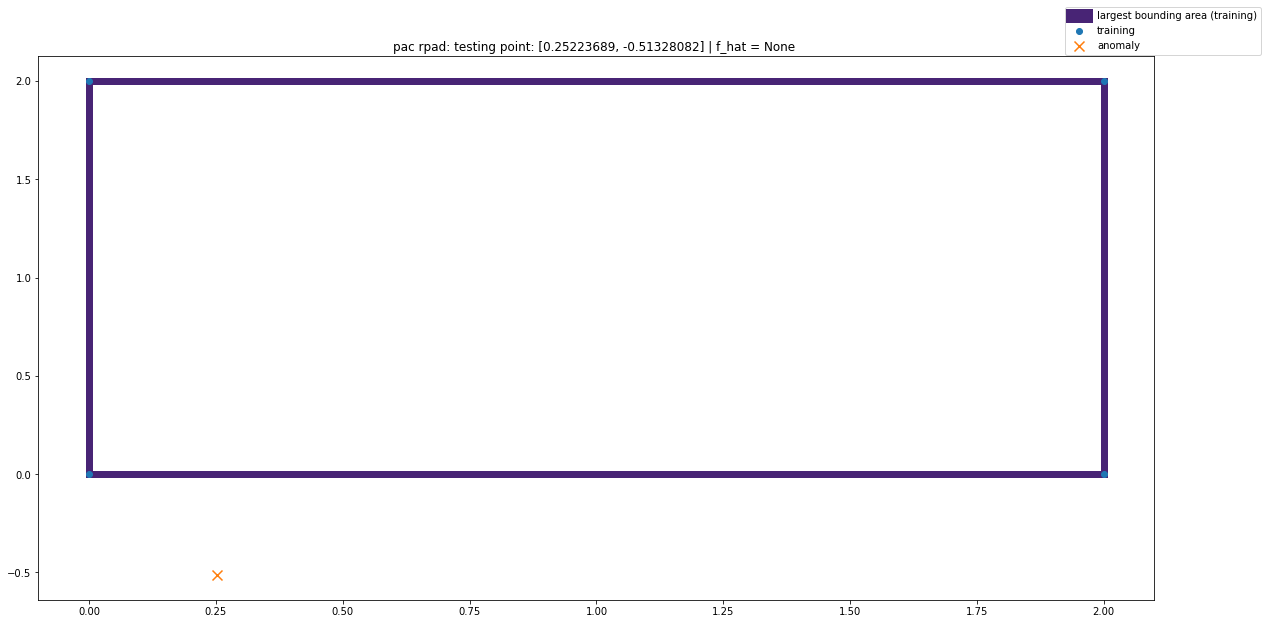

pattern:  [[ 1.00003001e-03  1.99899997e+00]
 [-4.66607769e-09  1.99899997e+00]]


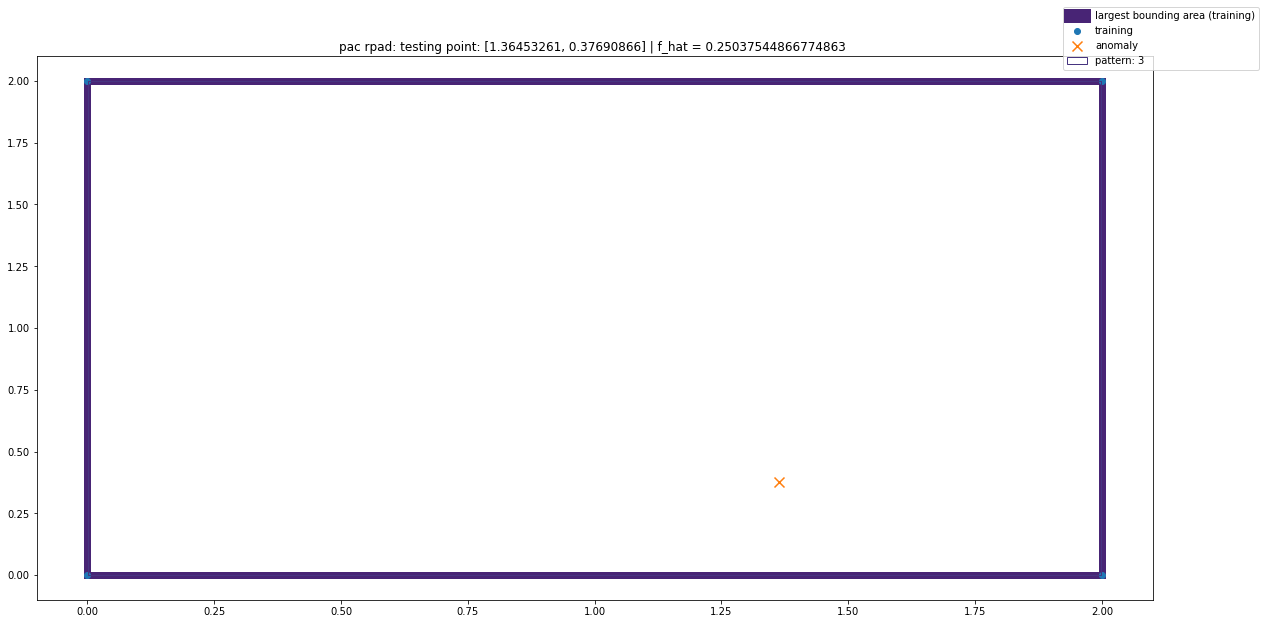

pattern:  None


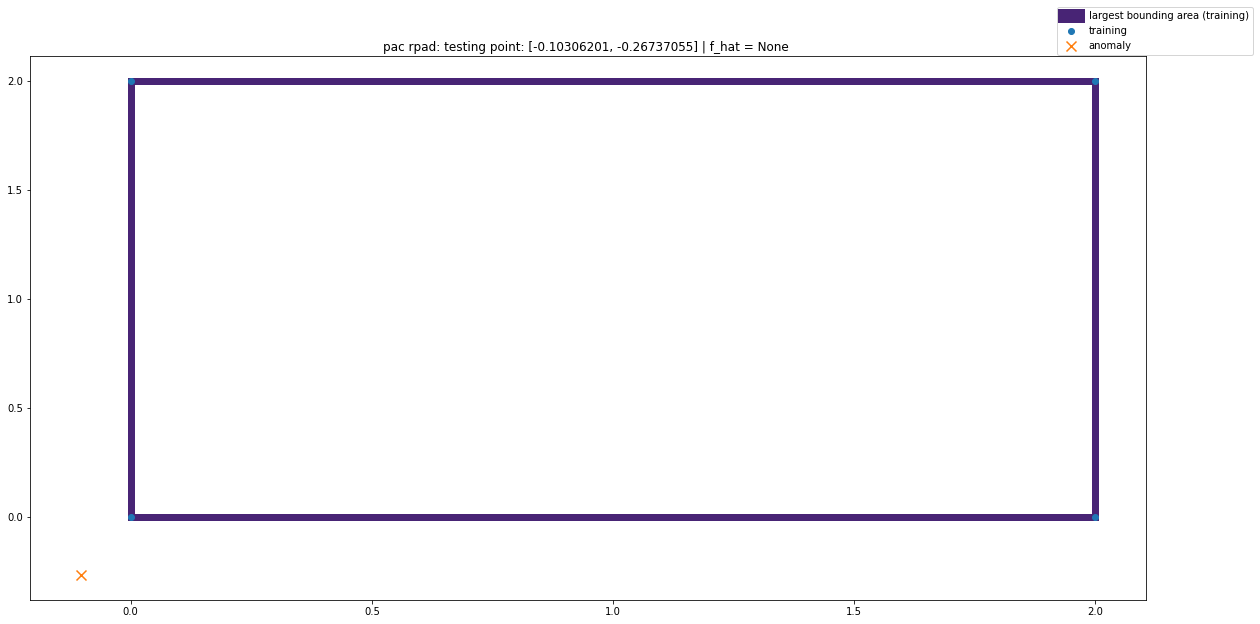

pattern:  None


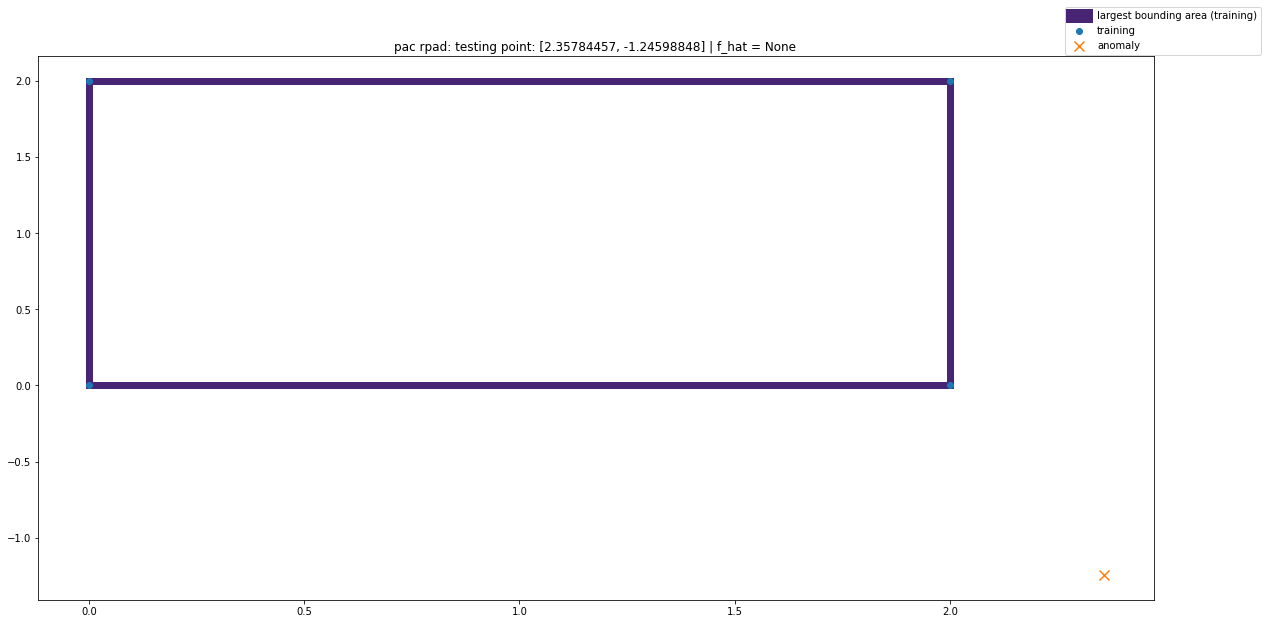

pattern:  [[-4.66607729e-09  1.99899997e+00]
 [ 1.00002993e-03  1.99899997e+00]]


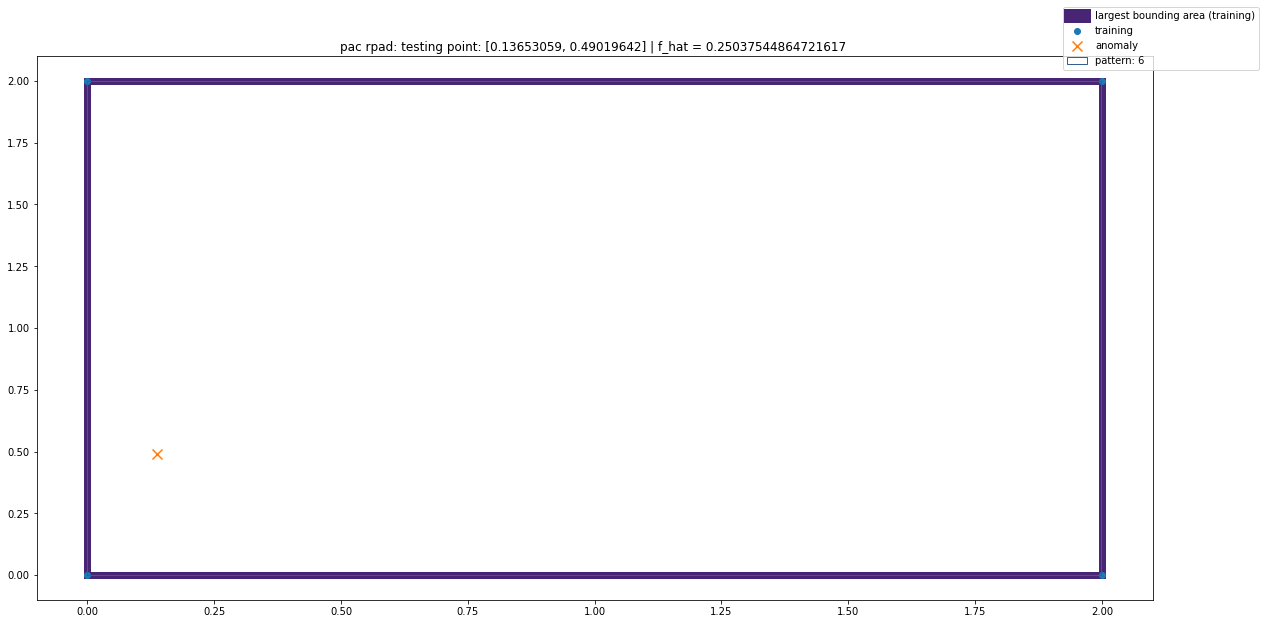

pattern:  None


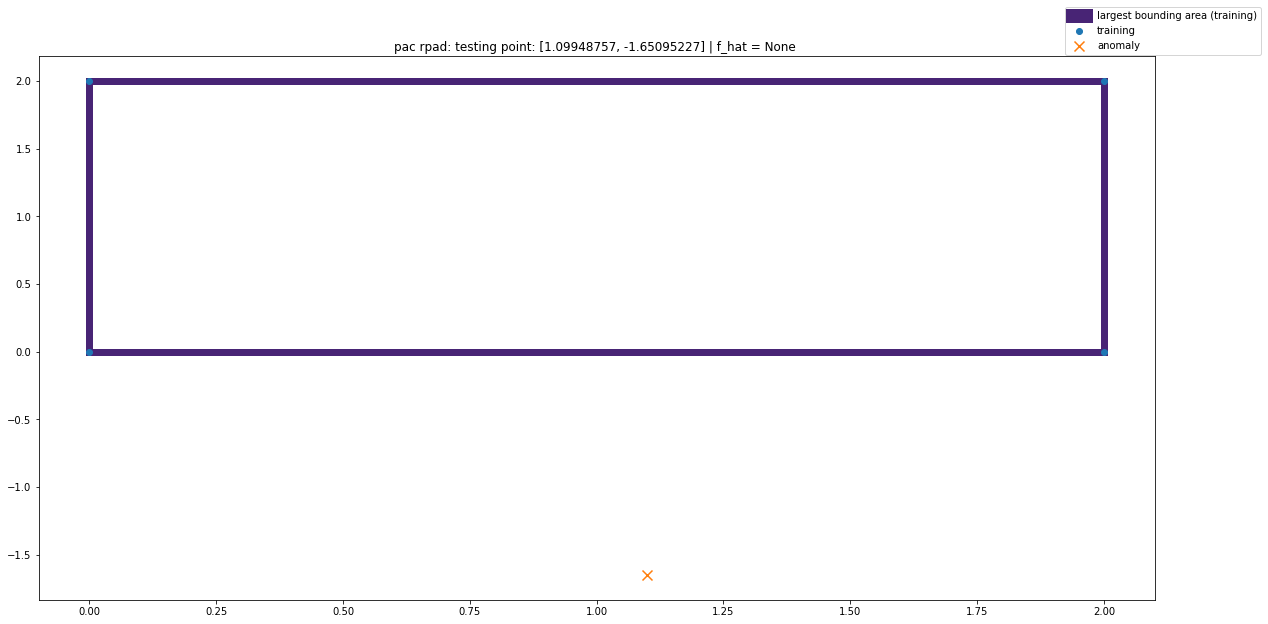

pattern:  None


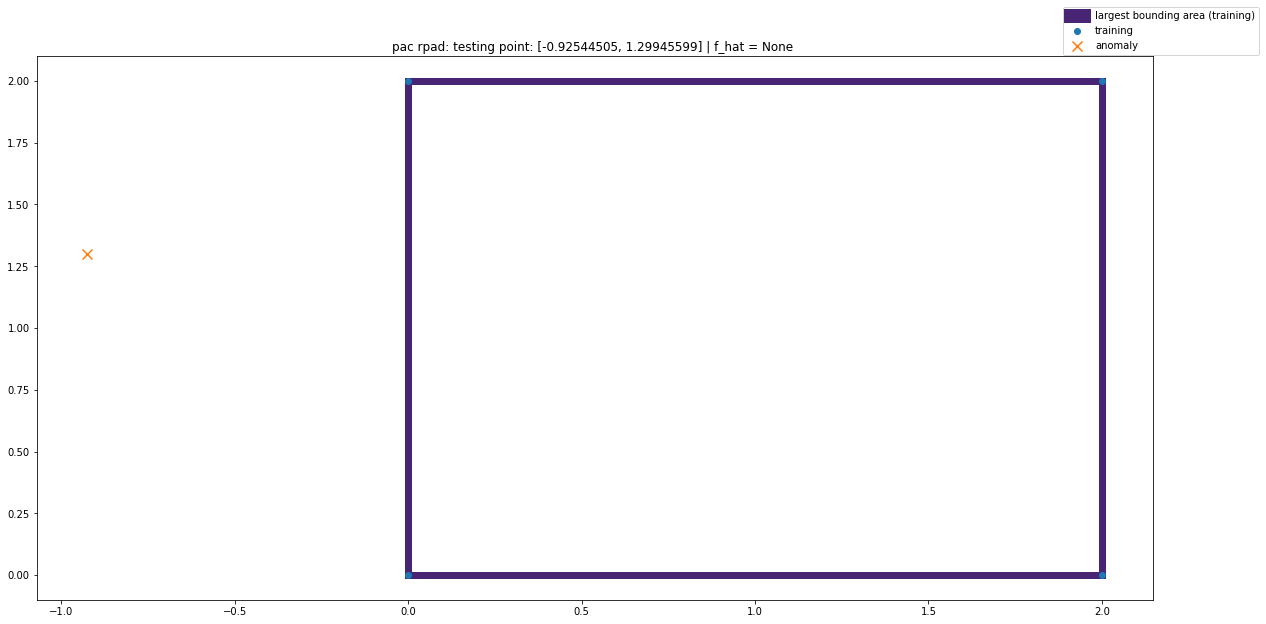

pattern:  None


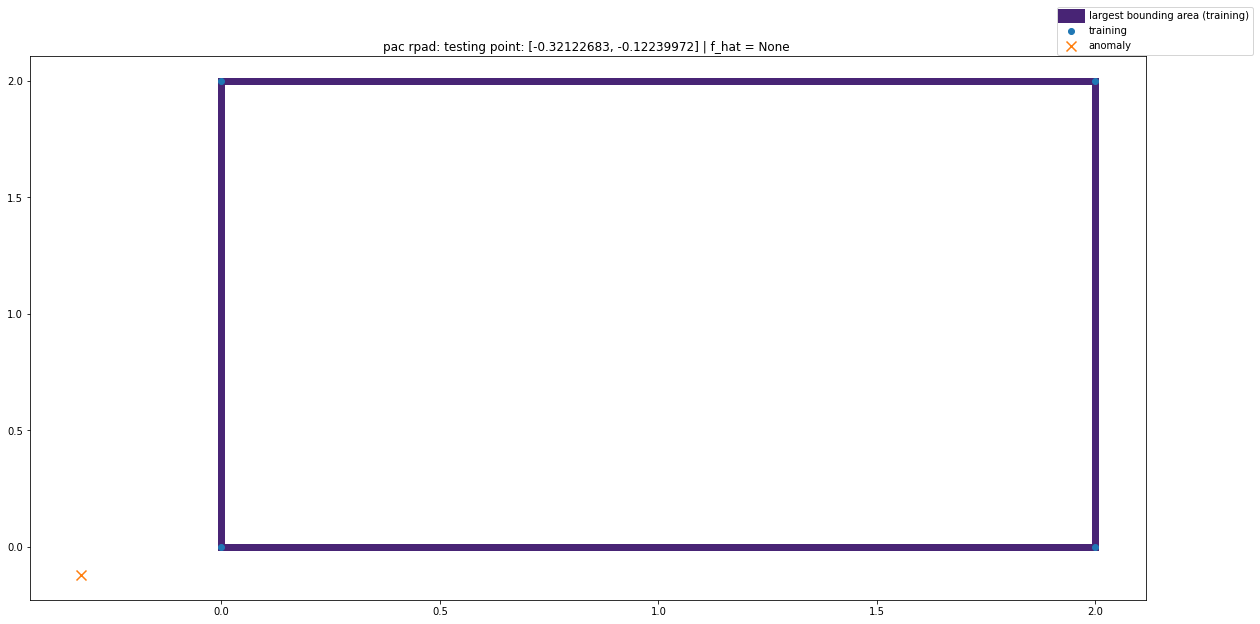

pattern:  None


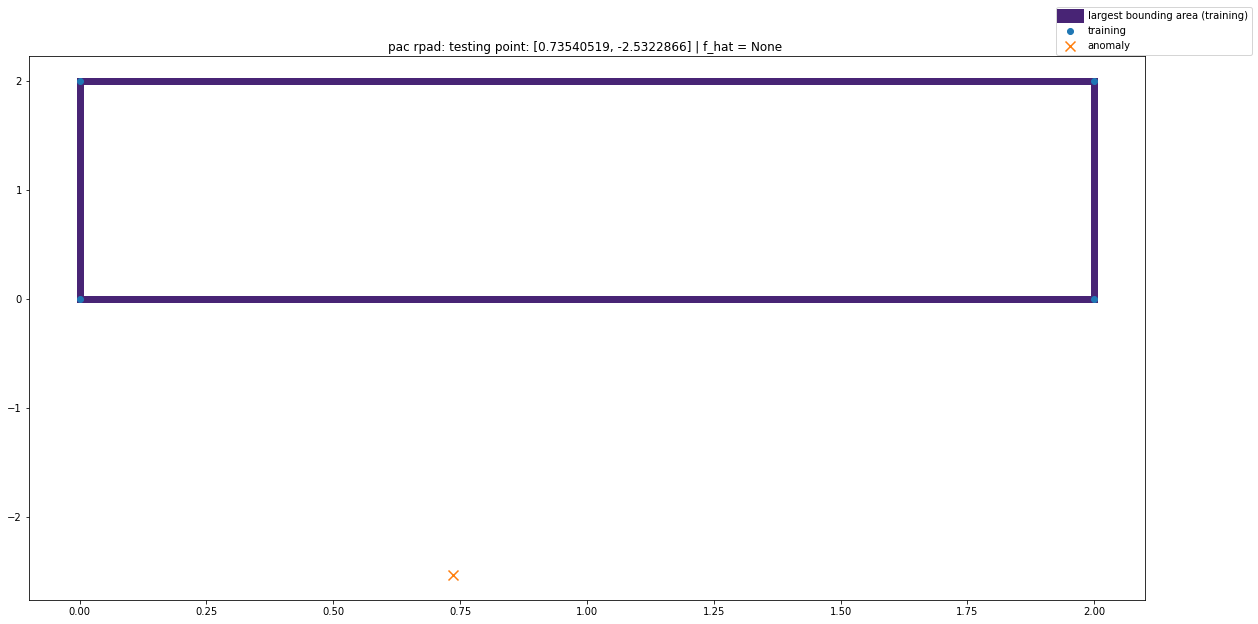

pattern:  [[-4.66607764e-09  1.99899997e+00]
 [ 1.00003001e-03  1.99899997e+00]]


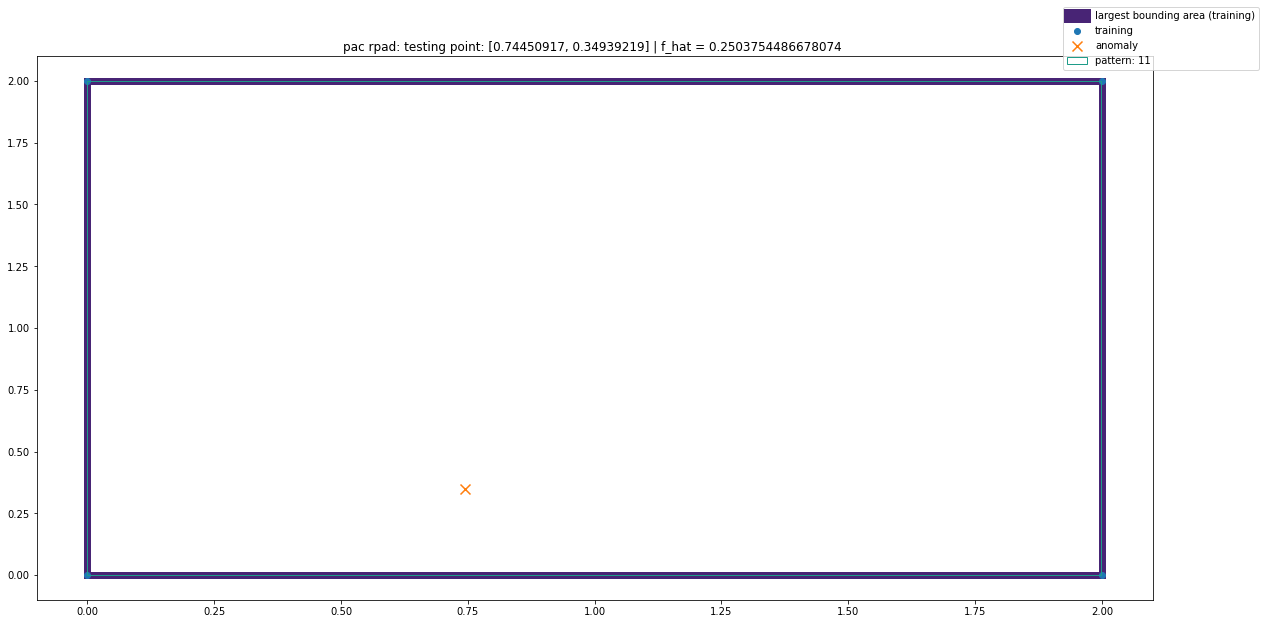

pattern:  None


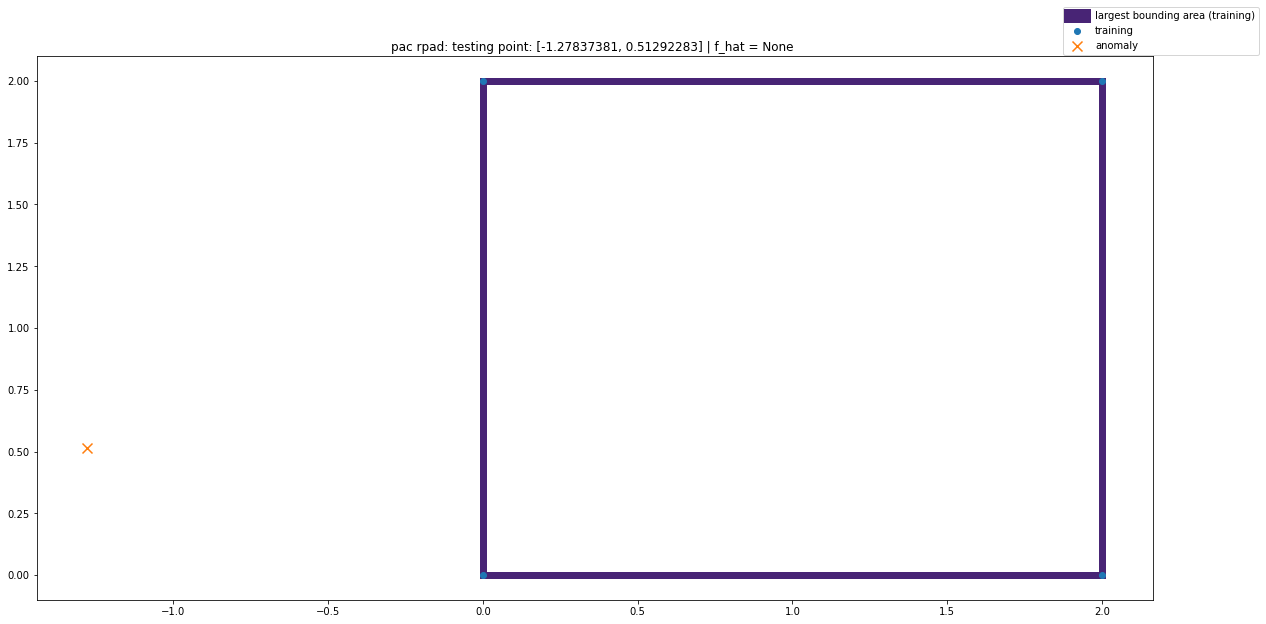

pattern:  [[-4.66607052e-09  1.99899997e+00]
 [ 1.00002981e-03  1.99899997e+00]]


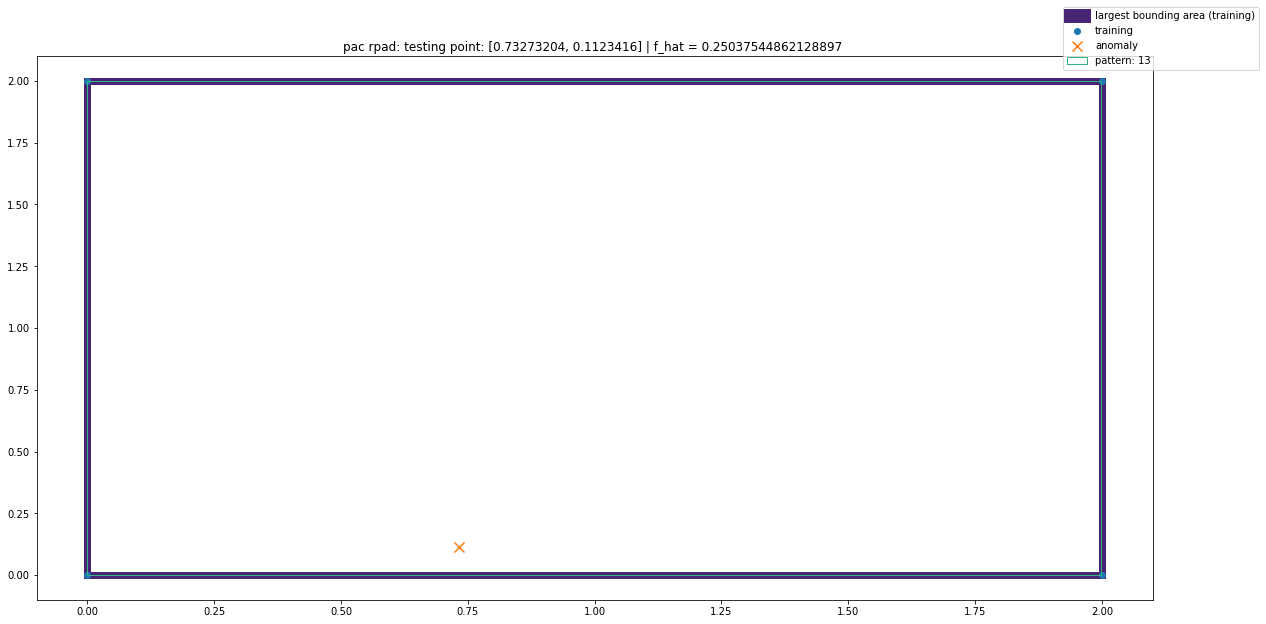

pattern:  [[-4.66607769e-09  1.99899997e+00]
 [ 1.00003001e-03  1.99899997e+00]]


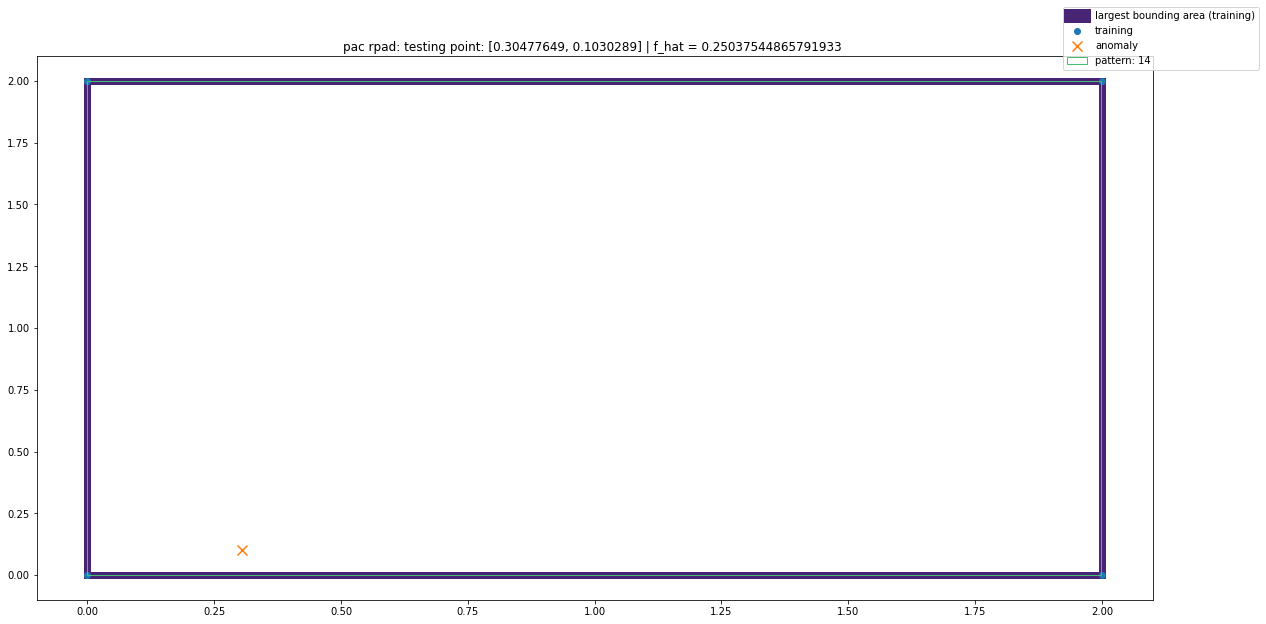

pattern:  [[-4.66607768e-09  1.99899997e+00]
 [ 1.00002996e-03  1.99899997e+00]]


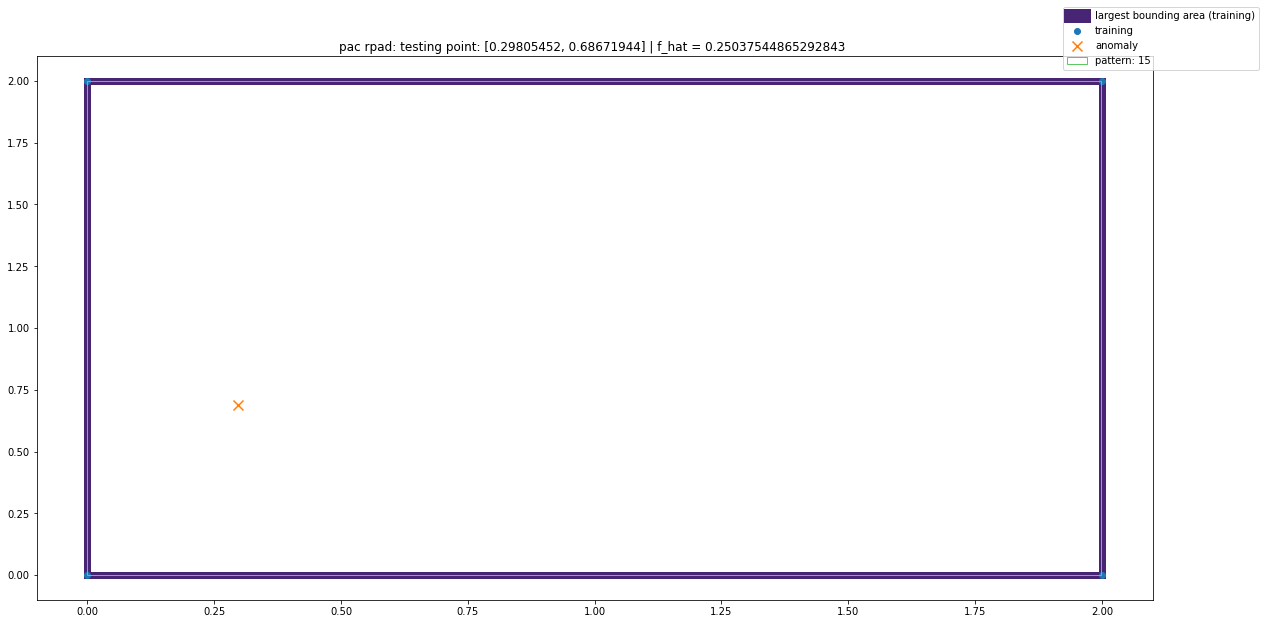

pattern:  None


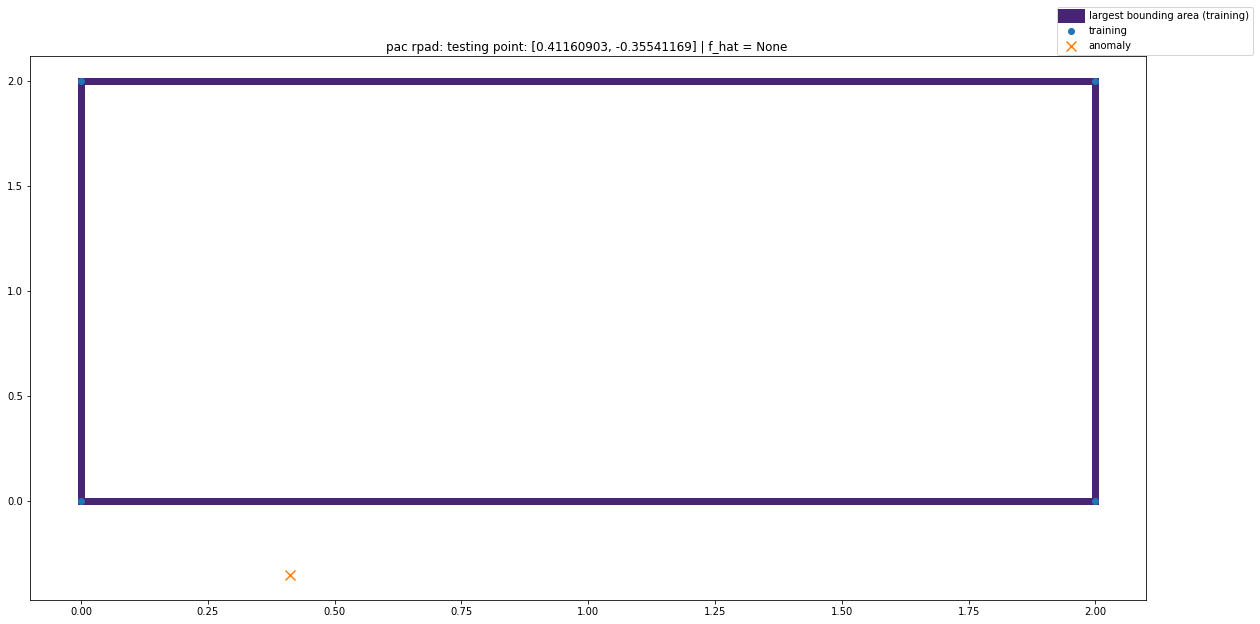

pattern:  [[ 1.00003001e-03  1.99899997e+00]
 [-4.66607766e-09  1.99899997e+00]]


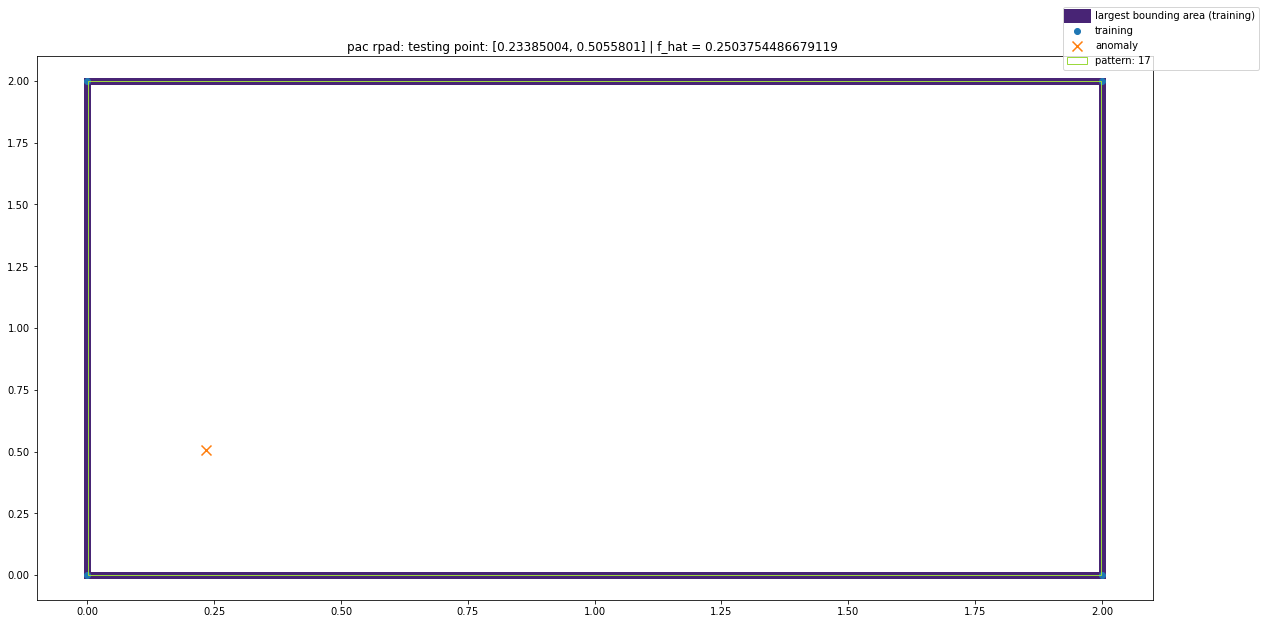

pattern:  None


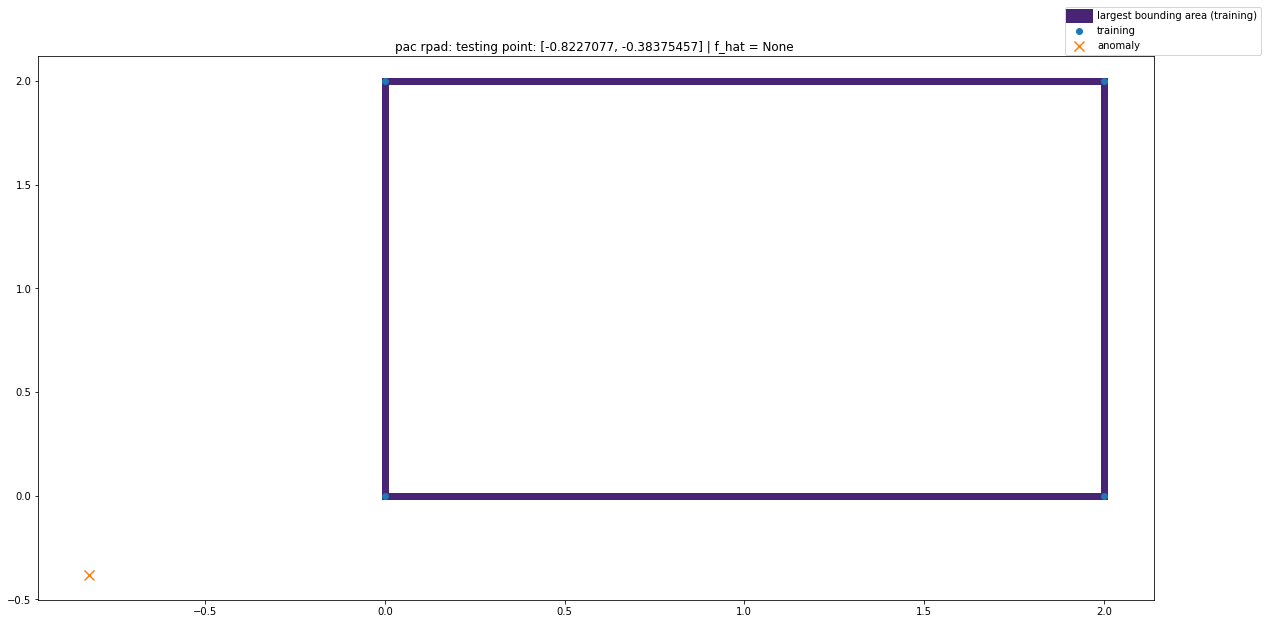

pattern:  None


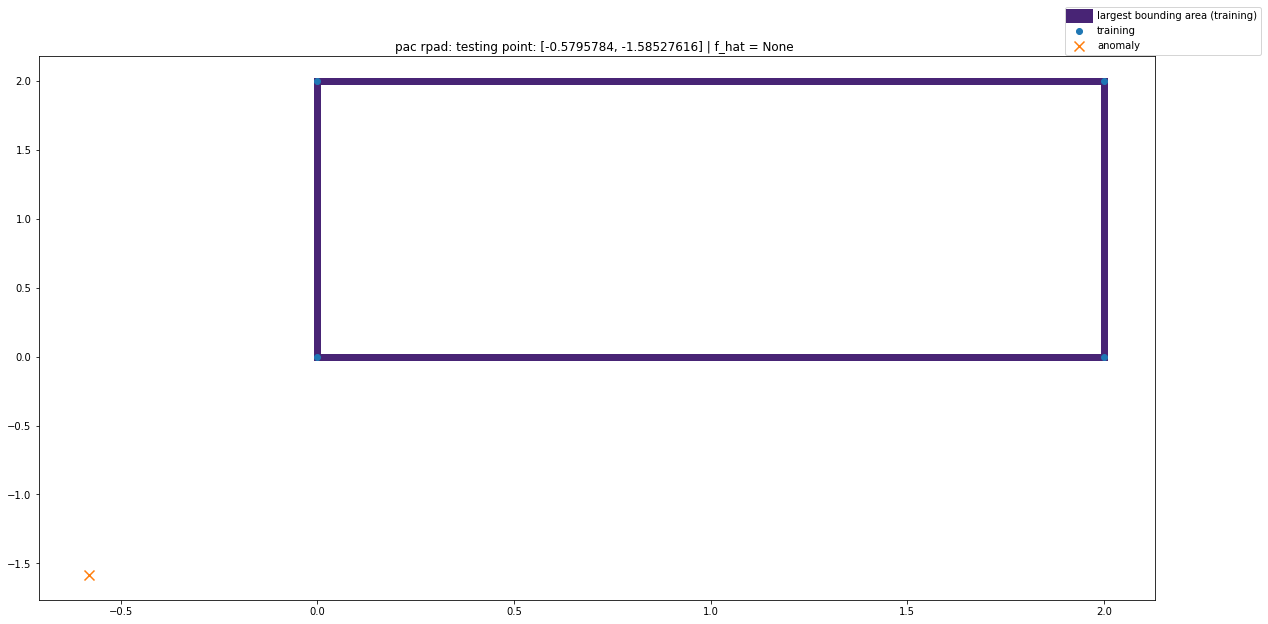

In [531]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,10)
cmap = plt.get_cmap('viridis')


def draw_largest_bounding_area(interval, ax):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(0.1),
        label= "largest bounding area (training)",
        linewidth=7.0
        )
    )


total = len(testing_points)
for i, (k,v) in enumerate(exact.find_min_f_hat.items()):
    ax = plt.gca()
    k = [float(x) for x in k[1:-1].split(" ") if x]
    point = k # exact.testing_points[i]
    draw_largest_bounding_area(exact.solver.largest_bounding_area.T, ax)
    ax.scatter(x=exact.training_points[:,0], y=exact.training_points[:,1], marker="o", label="training")
    pattern = np.array(v['pattern'])
    anomaly = v['anomaly']
    f_hat = v['objective']
    if anomaly:
        plt.scatter(x=k[0], y=k[1], marker="x", s=100, label="anomaly")
        print("pattern: ", pattern)
        if pattern.all() != None:
            draw2dpattern(pattern, ax, i, total)
    else:
        draw2dpattern(pattern, ax, i, total)
        ax.scatter(x=point[0], y=point[1], marker="x", s=150, label=f"testing point: {k}: normal")
    ax.legend(bbox_to_anchor=(1.1, 1.1))
    plt.title(f"pac rpad: testing point: {k} | f_hat = {f_hat} ")
    plt.show()


In [ ]:
# TODO: TEST !!!
    # - implemenent simple test (4 points where the correct answer is already known)
    #   - find the correct pattern, respect the boundaries in each of the dim, use simplest training set and simplest test point 
    #   - training set: (0.0,0.0) (2.0,0.0) (0.0,2.0) (2.0,2.0)
    #   - testing point: (1.0,1.0) 
    #   - unit test to test the functionnalities of the functions 
        # run solver and compare with the expected result 
            # - for the pattern intervals 
            # - for the min area 
            # - for the largest_bounding_area
    
# - one important thing is to think about how to configure the min_area value depending on the dataset.
    # min area: fraction of the bounding area, makes it dependent on the number of training points!  

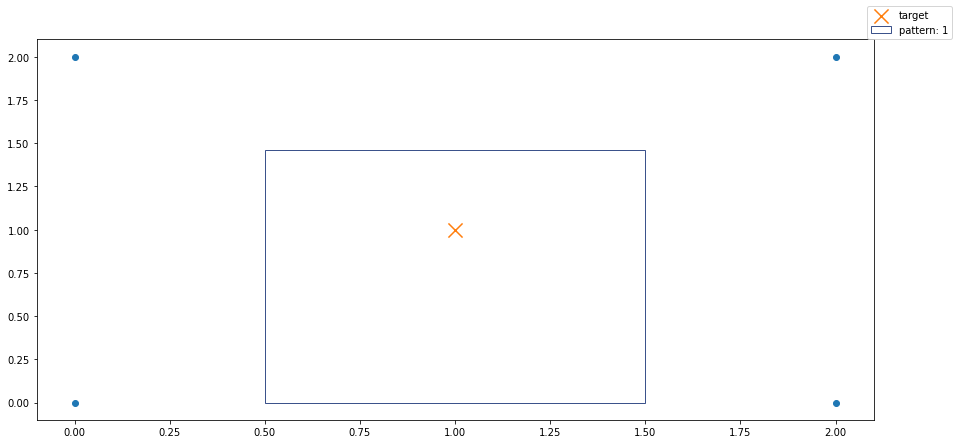

In [532]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,7)

cmap = plt.get_cmap('viridis')

def draw2dpattern(interval, ax, index, total):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(index/total),
        label=f"pattern: {index}"
        )
    )


plt.scatter(x=training_points[:,0], y=training_points[:,1])
plt.scatter(x=point_to_be_classified[0], y=point_to_be_classified[1], marker="x",  s=200, label="target") 
for i, p in enumerate(included_points):
    plt.scatter(x=p[0], y=p[1], marker="o", s=200, label=f"included point: {np.argwhere(training_points == p)[0,0]}")
ax = plt.gca()
draw2dpattern(intervals, ax, 1, len(training_points))
ax.legend(bbox_to_anchor=(1.1, 1.1))
plt.show()

In [ ]:
# min x , min y 
# max x , max y
rare_pattern_detect.largest_bounding_area

array([[-1.94093732, -0.48952549],
       [ 1.40174114,  1.78211652]])

In [ ]:
from typing import Callable
import numpy as np
import json

class PACRPAD:
    """
    Superclass for all PAC-RPAD implementations
    """
    def __init__(self, tau, epsilon, delta):
        self.tau = tau
        self.epsilon = epsilon
        self.delta = delta
        self.find_min_f_hat = None

    def has_rare_pattern(self, point) -> bool:
        results = self.find_min_f_hat[f"{point}"]
        if results['objective'] != None:
            results['anomaly'] = results['objective'] <= self.tau + self.epsilon / 2
        return results['anomaly']


class AxisAlignedHyperRectanglePACRPAD(PACRPAD):
    def __init__(self, tau, epsilon, delta):
        super().__init__(tau, epsilon, delta)
        self.solver = None 
        self.training_points = None
        self.testing_points = None

    def construct_f_hat_estimator(self, training_points, testing_points, min_area=0.01):
        def _contains(point: np.ndarray, largest_bounding_area) -> bool:
            return all((largest_bounding_area[0,:] <= point.T) & (point.T <= largest_bounding_area[1,:]))

        self.training_points = training_points
        self.testing_points = testing_points
        dict_results = {}

        # Check if testing points lie within the initial pattern bounds
        dummy_solver = RarePatternDetect(self.training_points, min_area=min_area)
        candidates = []
        for idx, test_p in enumerate(self.testing_points):
            # TODO: extract the largest_bounding_area outside of the solver 
            # TODO: extract the functionalities of evaluating to has rare pattern 
            contained = _contains(test_p, dummy_solver.largest_bounding_area)
            if contained:
                # if yes then add testing_points to ensemble of points used to create the pattern space 
                candidates = [train_p for train_p in self.training_points]
                candidates = np.array(candidates)
                candidates = np.append(candidates, [test_p], axis=0)
                self.solver = RarePatternDetect(candidates, min_area=min_area)
                objective = self.solver.classify(test_p)
                intervals = self.solver.extract_pattern()
                included_points = self.solver.extract_points_included_in_pattern()
                dict_results[f"{test_p}"] =  {
                    'index' : idx,
                    'anomaly' : None,
                    'objective' : objective, 
                    'pattern' : intervals.tolist(), 
                    'included points' : included_points.tolist()
                }
            else:
                # else: anomaly = True
                dict_results[f"{test_p}"] =  {
                    'index' : idx,
                    'anomaly' : True,
                    'objective' : None, 
                    'pattern' : None, 
                    'included points' : None
                }

        with open('minlp_results.json', 'w') as fp:
            json.dump(dict_results, fp, indent=4)

        self.find_min_f_hat = dict_results

In [ ]:
exact = AxisAlignedHyperRectanglePACRPAD(tau=0.3, epsilon=0.1, delta=0.1)

In [ ]:
testing_points = multivariate_normal.rvs(size=(20,2))
testing_points

array([[-0.59927506, -0.06224411],
       [ 0.17616437,  0.25597627],
       [ 0.24706689,  0.88134082],
       [-1.32195338, -0.08494975],
       [-0.35685015, -0.03464187],
       [ 0.51366633,  1.78902447],
       [ 1.21072746,  1.49624383],
       [-0.41745004,  0.12271633],
       [-0.04427169, -1.5238549 ],
       [-0.29935778, -0.1664545 ],
       [-0.66310021,  0.11776313],
       [ 0.41948961, -0.8674315 ],
       [ 1.92870069, -1.34921626],
       [ 0.73827368,  0.18761191],
       [ 0.6143559 ,  1.78560001],
       [-0.15479567,  0.01978228],
       [-0.01634013,  1.11670555],
       [ 1.65572959,  1.32390065],
       [-0.63774835,  0.51752167],
       [ 1.04244384, -0.40406151]])

In [533]:
exact.construct_f_hat_estimator(training_points, testing_points, min_area=0)
labels_pac_minlp = [exact.has_rare_pattern(x) for x in exact.testing_points]
labels_pac_minlp

    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
model.interval_lengths:  interval_lengths
    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 52 constraints (1 nonlinear) and 0 disjunctions, with 31 variables, of which 25 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



model.interval_lengths:  interval_lengths


         -       Relaxed NLP      -3.55004e-08            inf   -3.55004e-08      nan%      0.18
         1              MILP          0.810716            inf       0.810716      nan%      0.23
*        1         Fixed NLP          0.250375       0.250375       0.810716   223.80%      0.32
         2              MILP          0.810716       0.250375       0.810716   223.80%      0.35
Cycling happens after 2 main iterations. The same combination is obtained in iteration 1 This issue happens when the NLP subproblem violates constraint qualification. Convergence to optimal solution is not guaranteed.
Final bound values: Primal Bound: 0.2503754411736911  Dual Bound: 0.810716025765027
 Primal integral          :    0.0000 
 Dual integral            :    0.1491 
 Primal-dual gap integral :    0.1491 


    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 52 constraints (1 nonlinear) and 0 disjunctions, with 31 variables, of which 25 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



model.interval_lengths:  interval_lengths


Initial relaxed NLP problem is infeasible. Problem may be infeasible.
main MILP was unbounded. Resolving with arbitrary bound values of (-1e+15, 1e+15) on the objective. You can change this bound with the option obj_bound.
infeasibility detected in deactivate_trivial_constraints
NLP subproblem was locally infeasible.
Solving feasibility problem
Feasibility subproblem infeasible. This should never happen.
 Primal integral          :       nan 
 Dual integral            :       nan 
 Primal-dual gap integral :       nan 


ERROR: evaluating object as numeric value: interval_lengths[0]
        (object: <class 'pyomo.core.base.var._GeneralVarData'>)
    No value for uninitialized NumericValue object interval_lengths[0]
ERROR: evaluating object as numeric value: obj
        (object: <class 'pyomo.core.base.objective.ScalarObjective'>)
    No value for uninitialized NumericValue object interval_lengths[0]


ValueError: No value for uninitialized NumericValue object interval_lengths[0]

pattern:  [[-0.71023401  1.40074112]
 [-1.94093729  0.24309926]]


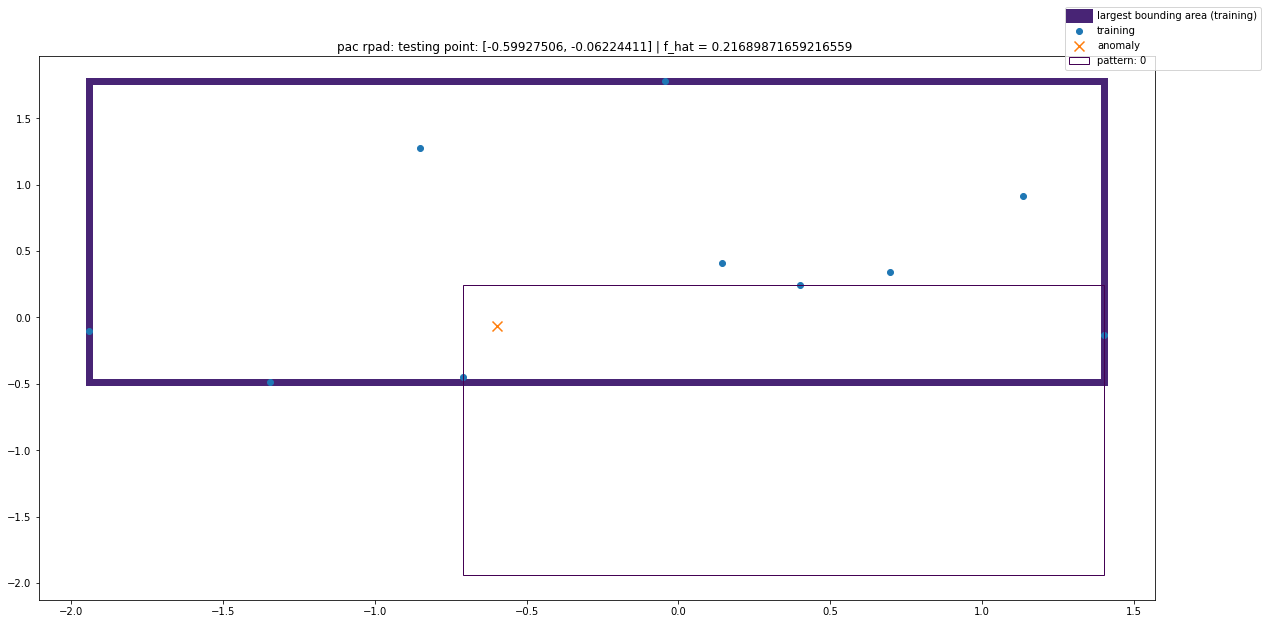

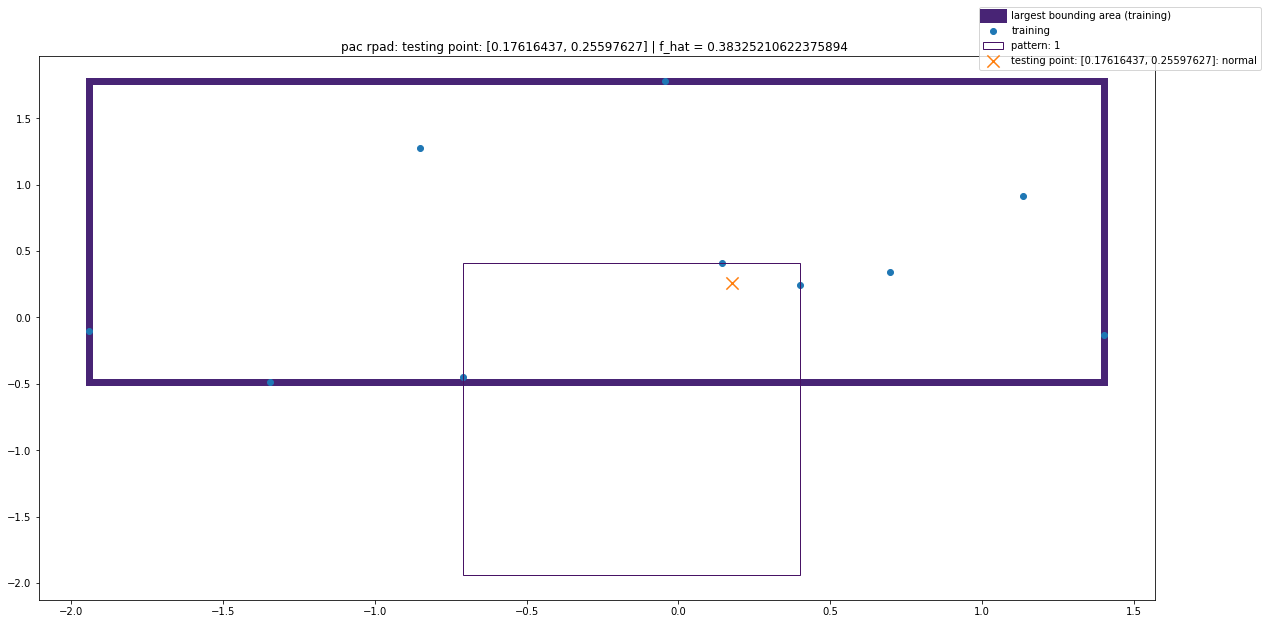

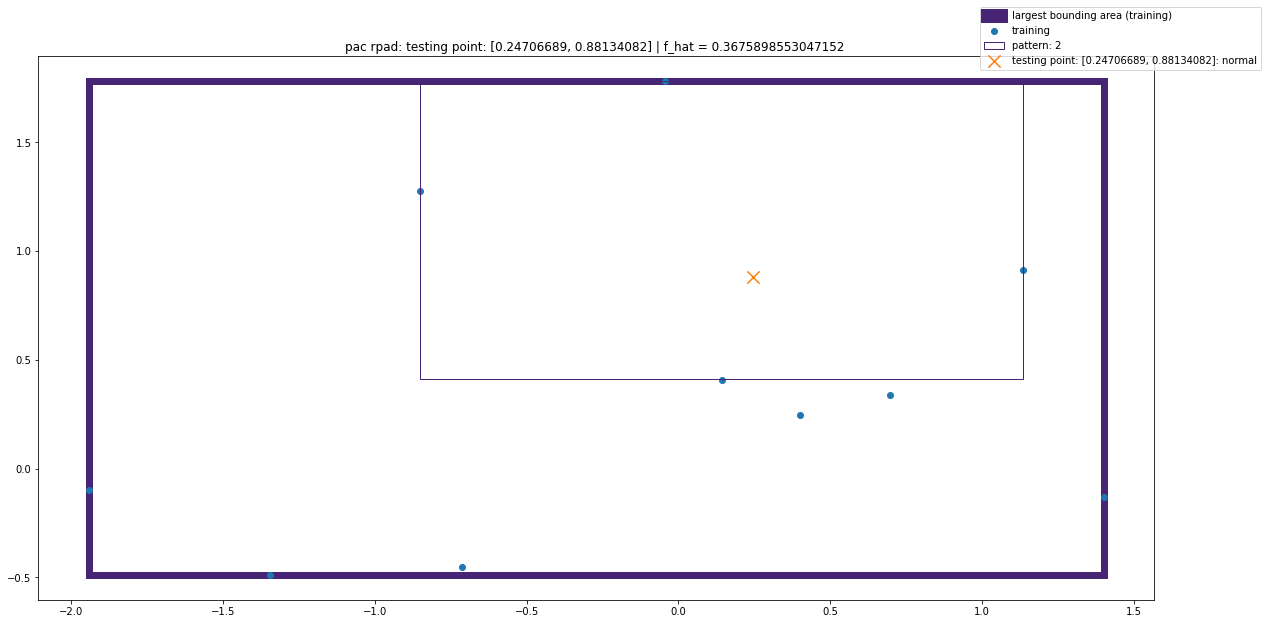

pattern:  [[-1.93993731  0.14147797]
 [-0.44992979  1.27526153]]


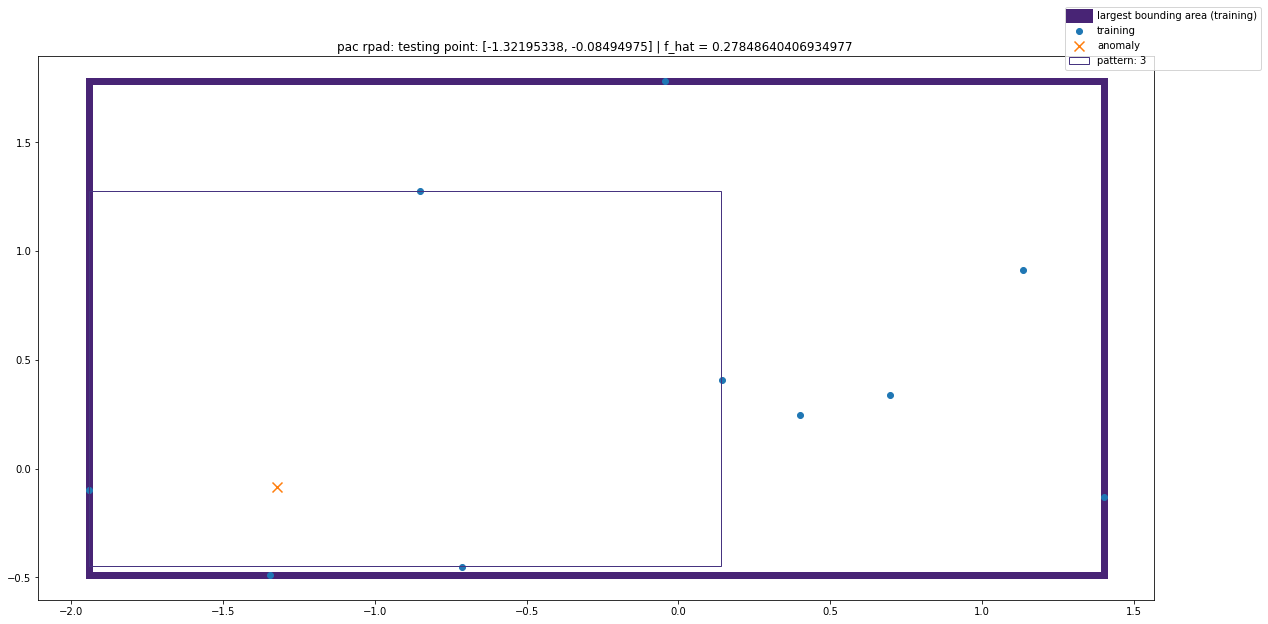

pattern:  [[-0.71023401  1.40074112]
 [-1.94093729  0.24309926]]


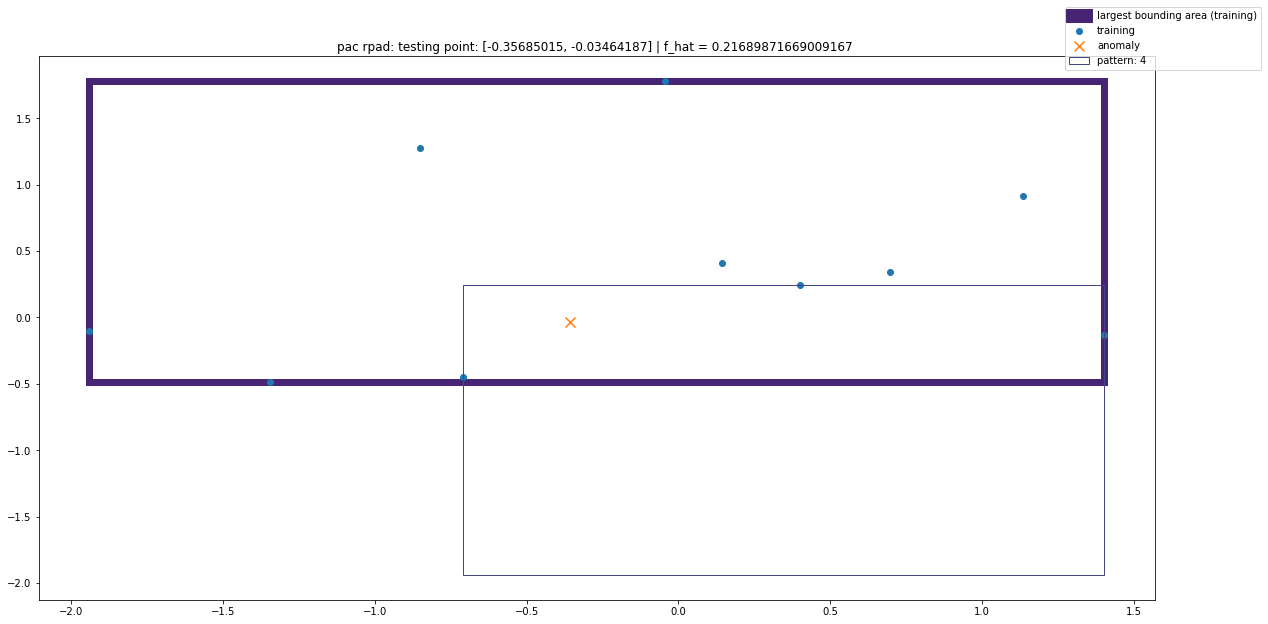

pattern:  None


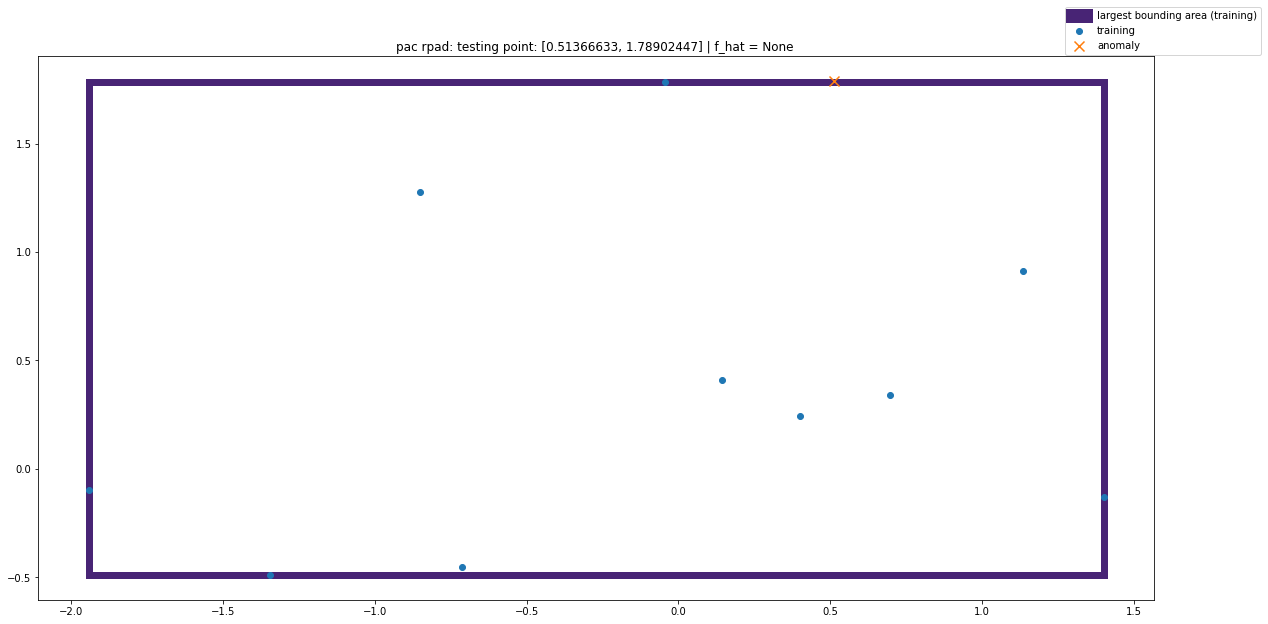

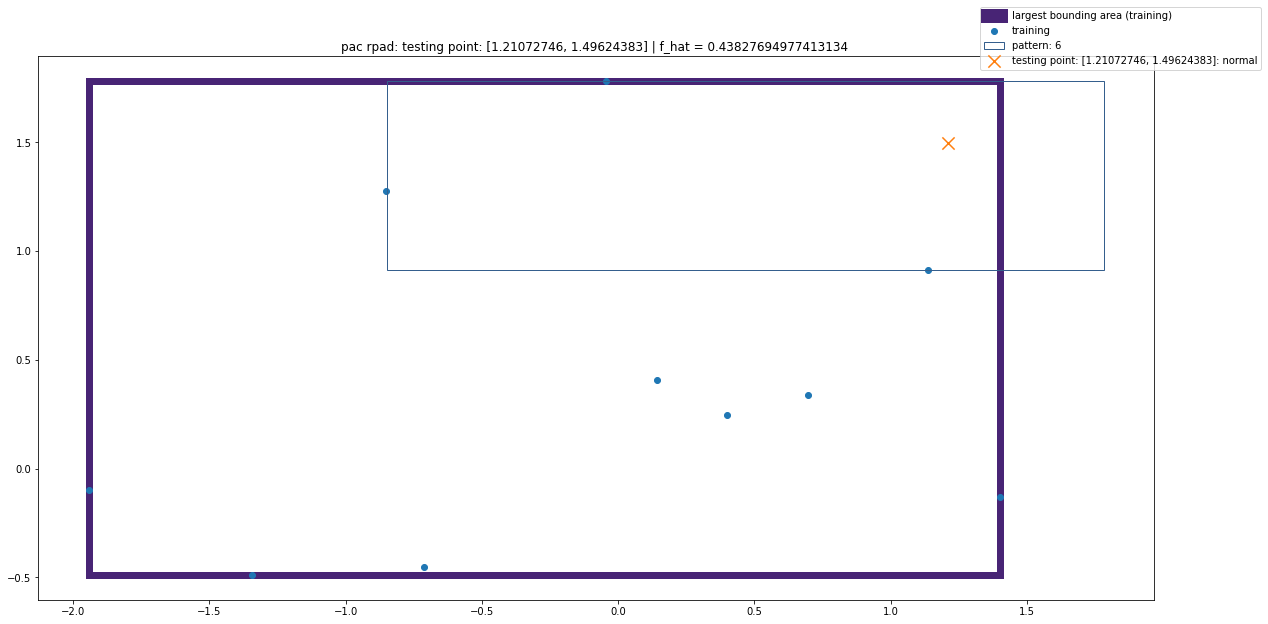

pattern:  [[-0.71023401  1.40074112]
 [-1.94093729  0.24309925]]


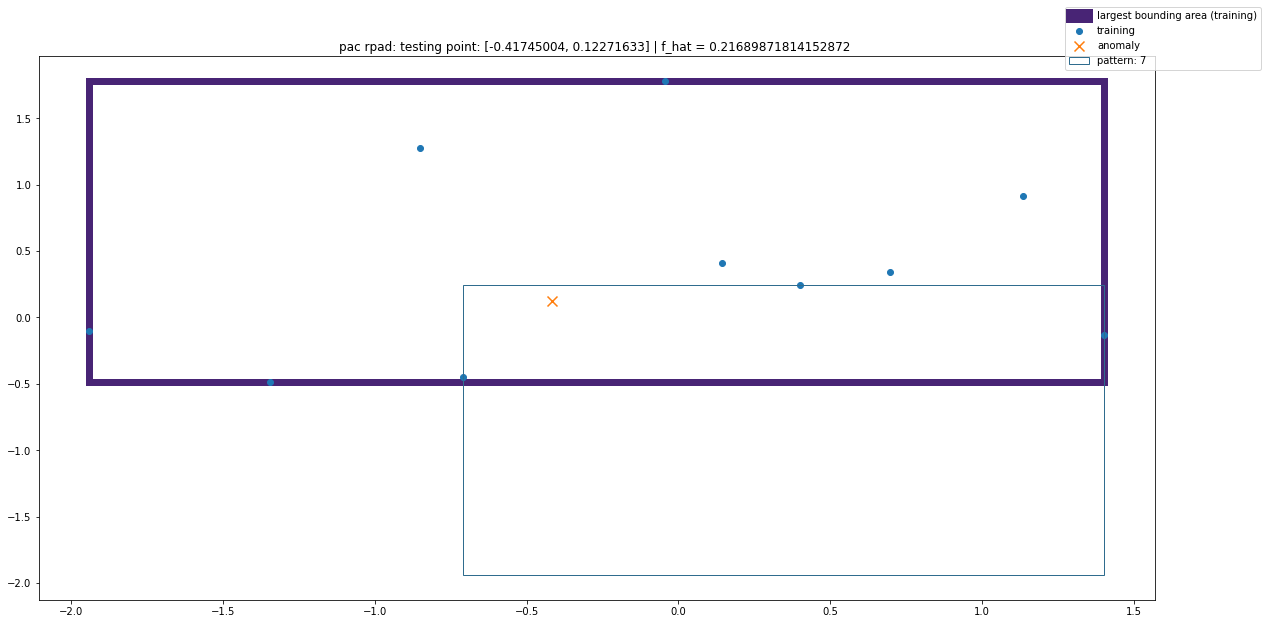

pattern:  None


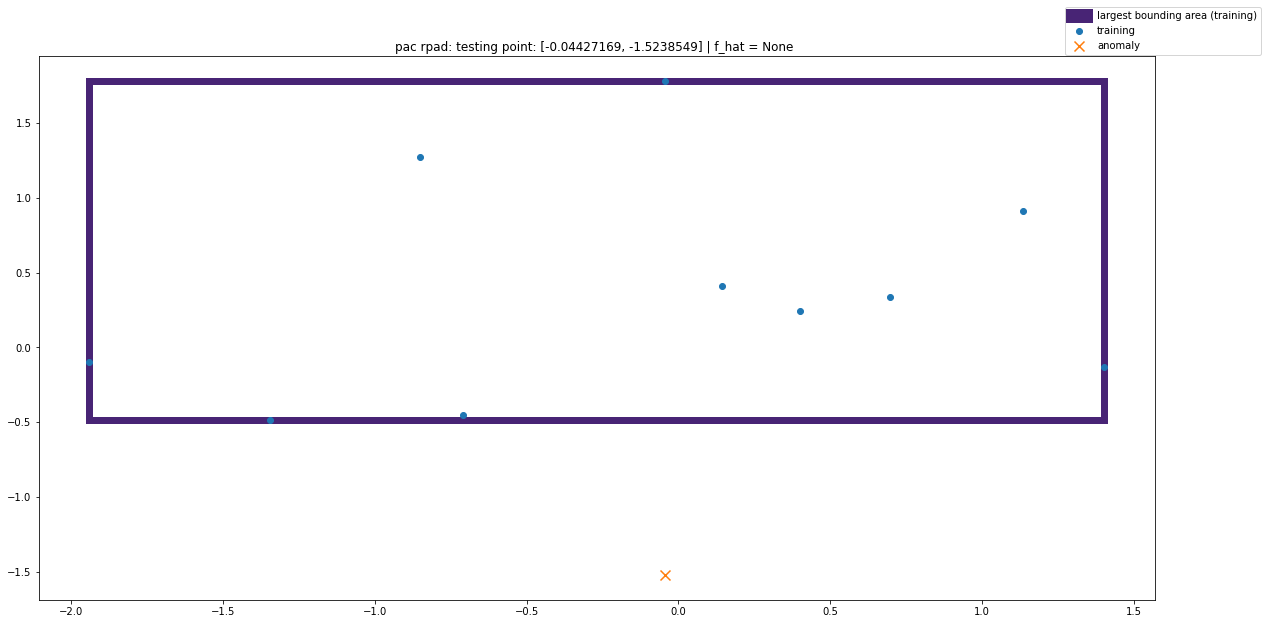

pattern:  [[-0.71023401  1.40074112]
 [-1.94093729  0.24309925]]


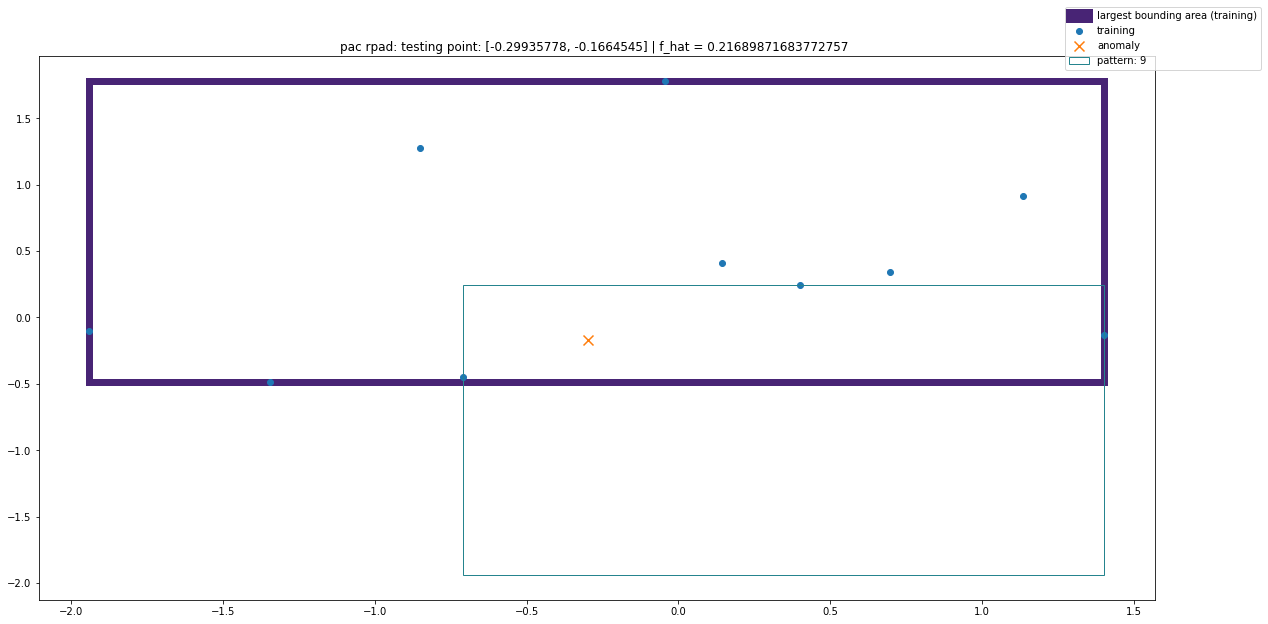

pattern:  [[-0.71023399  1.40074112]
 [-1.9409373   0.24309925]]


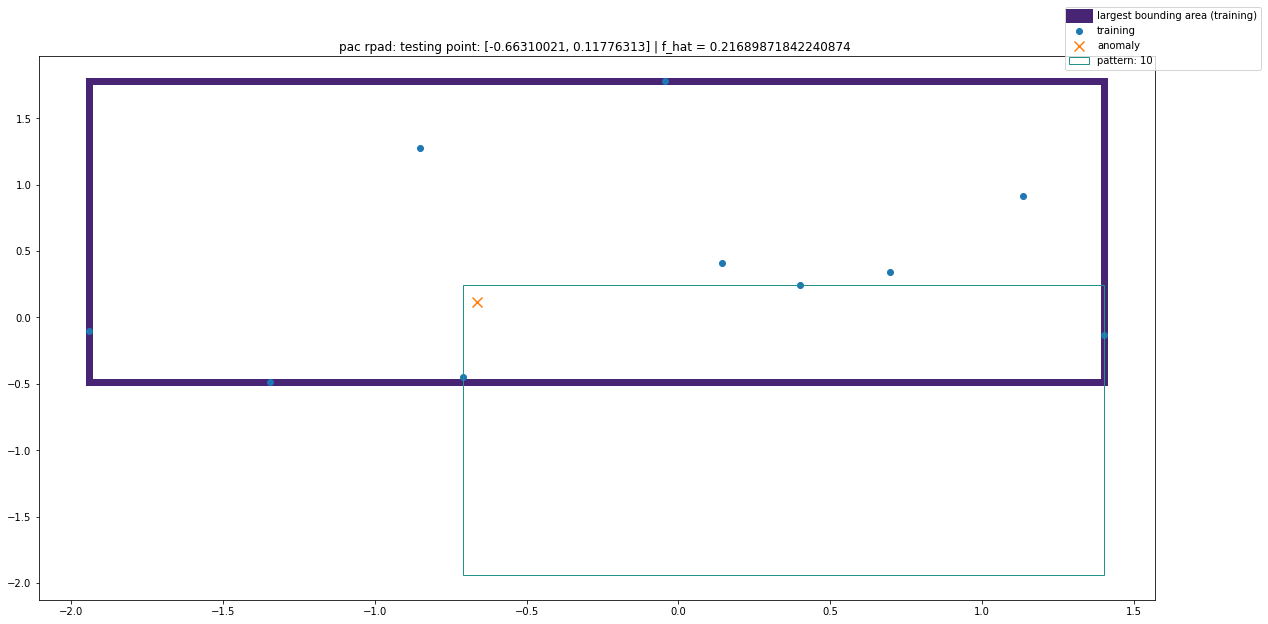

pattern:  None


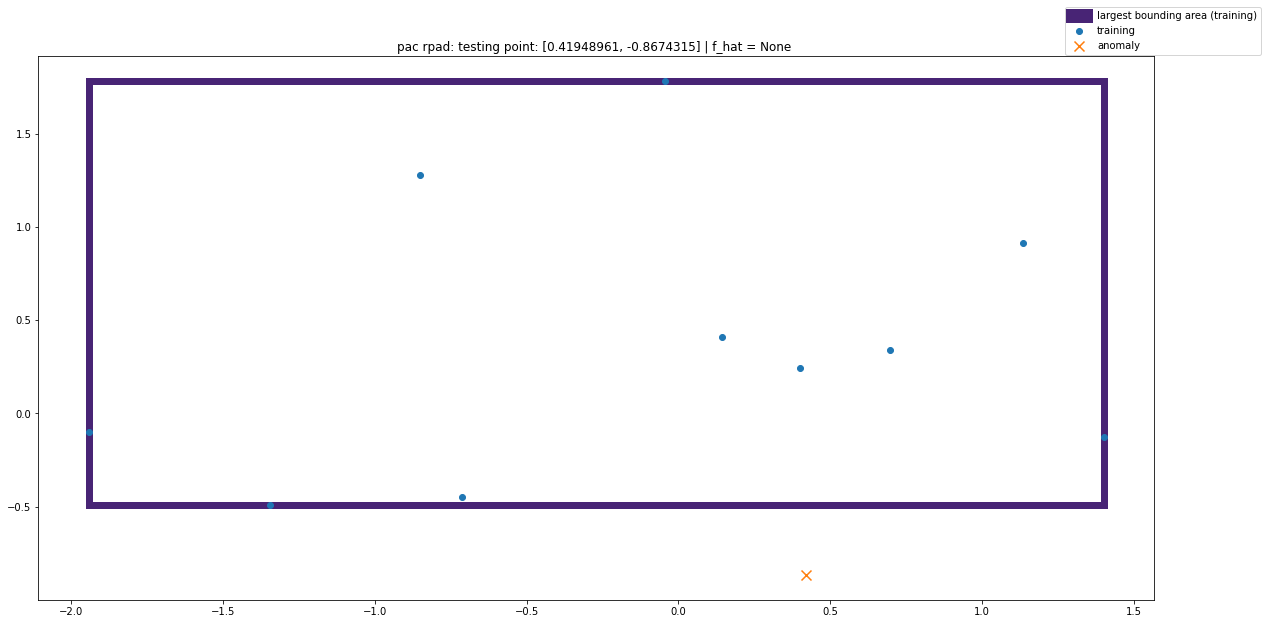

pattern:  None


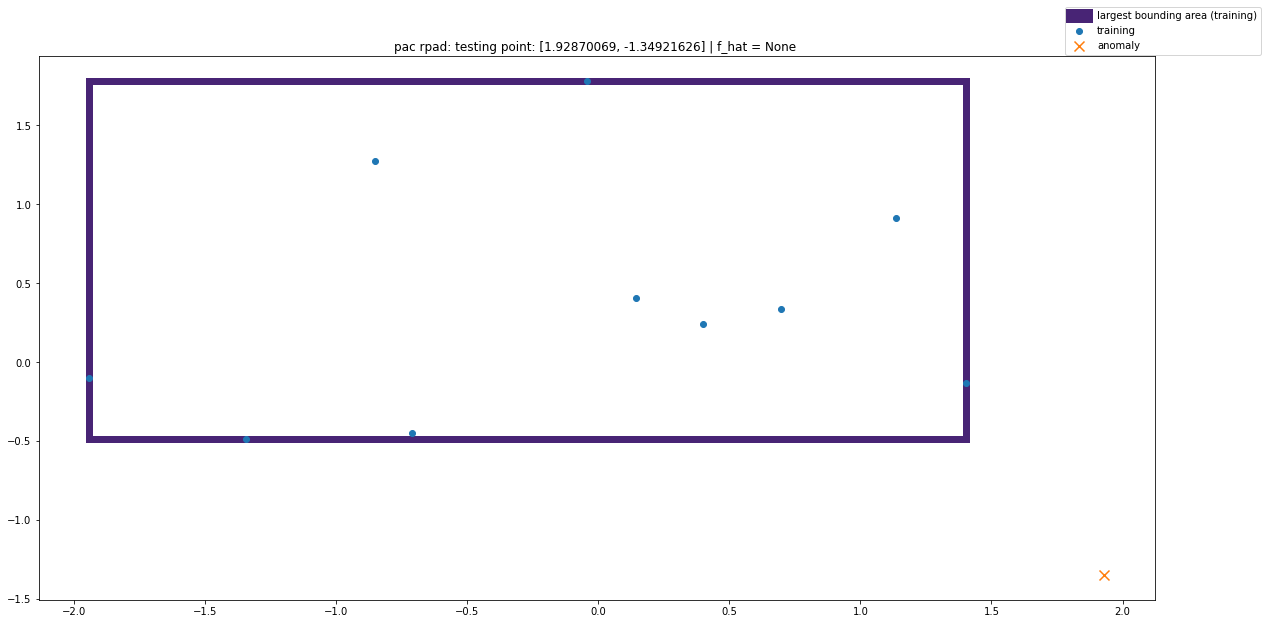

pattern:  [[-0.71023401  1.40074111]
 [-1.94093729  0.24309927]]


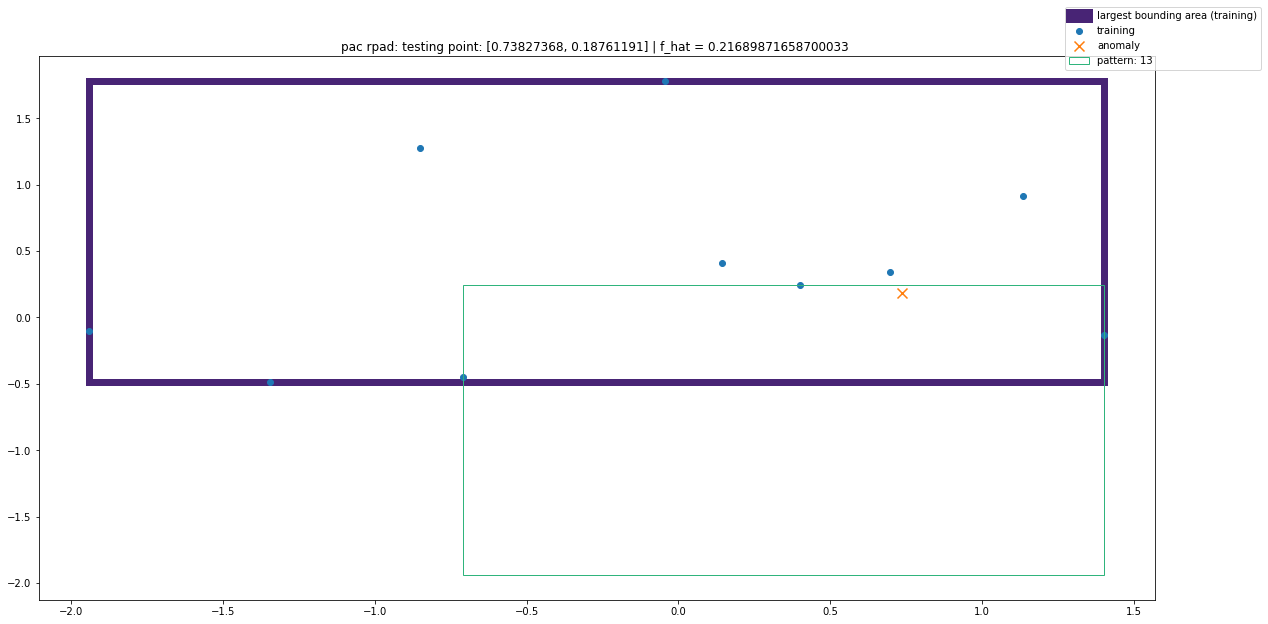

pattern:  None


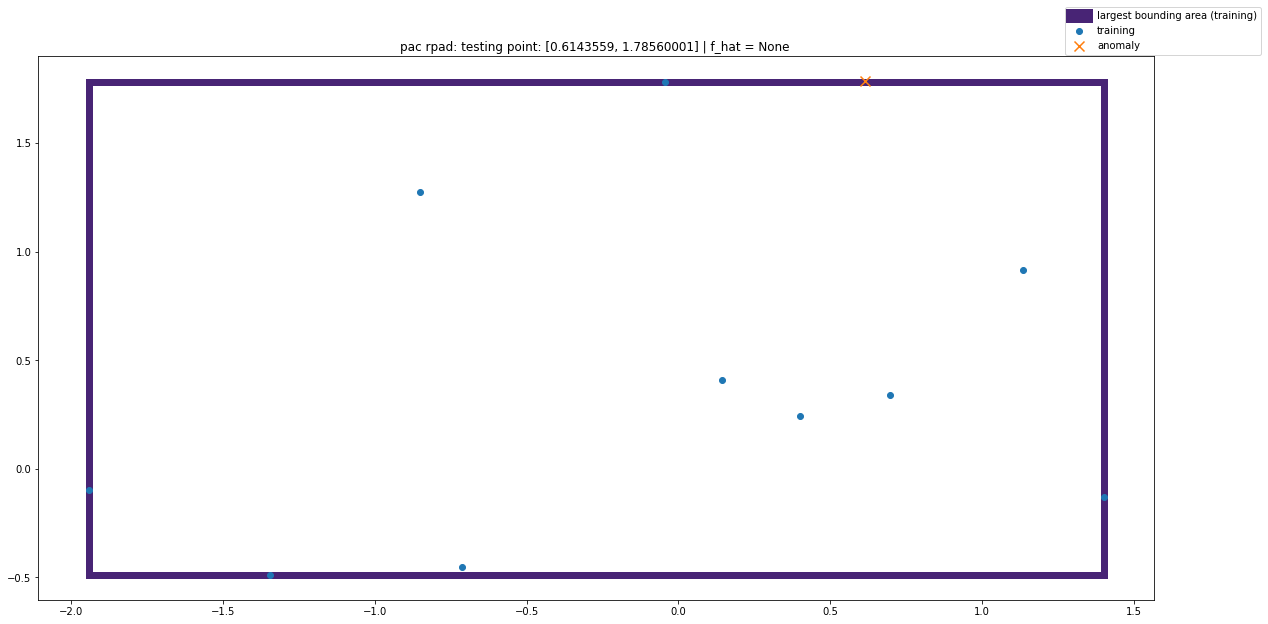

pattern:  [[-0.71023401  1.40074112]
 [-1.94093729  0.24309926]]


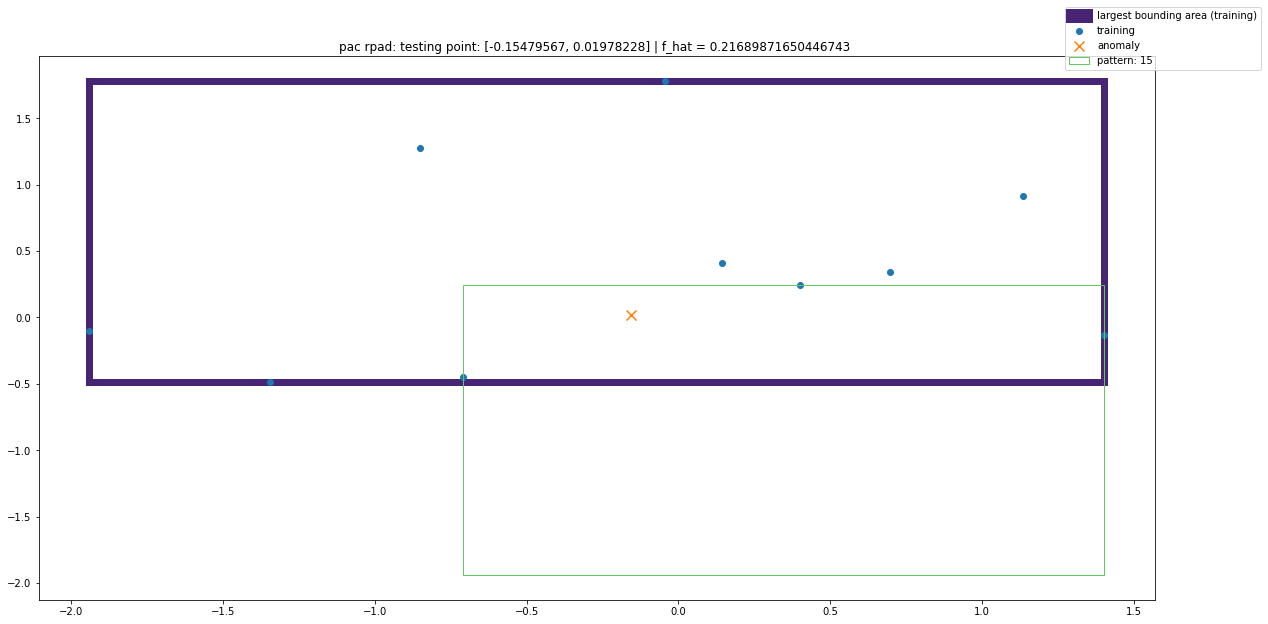

pattern:  [[-1.93993731  0.14147797]
 [-0.44992979  1.27526153]]


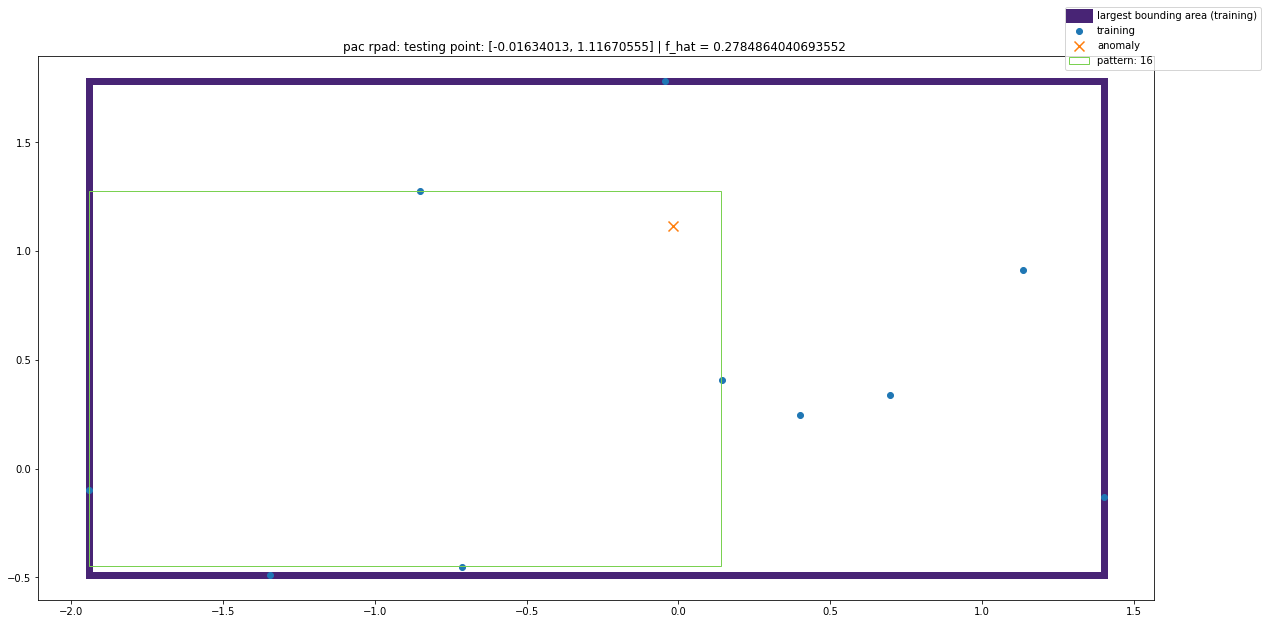

pattern:  None


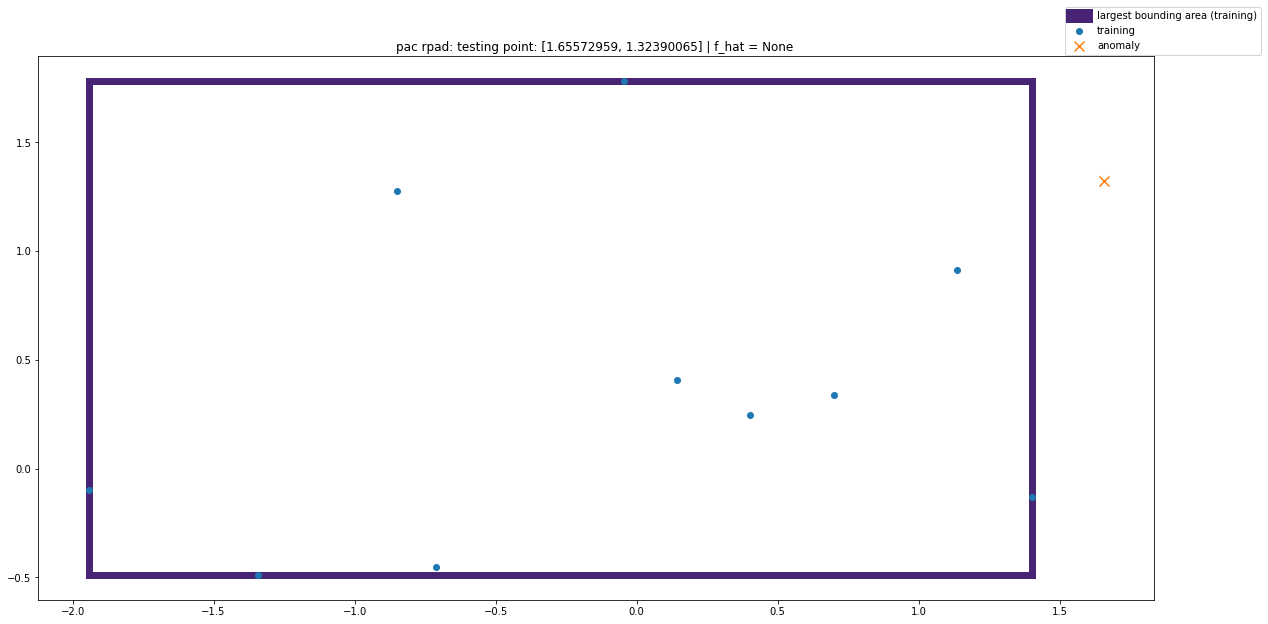

pattern:  [[-1.93993731  0.14147797]
 [-0.44992979  1.27526153]]


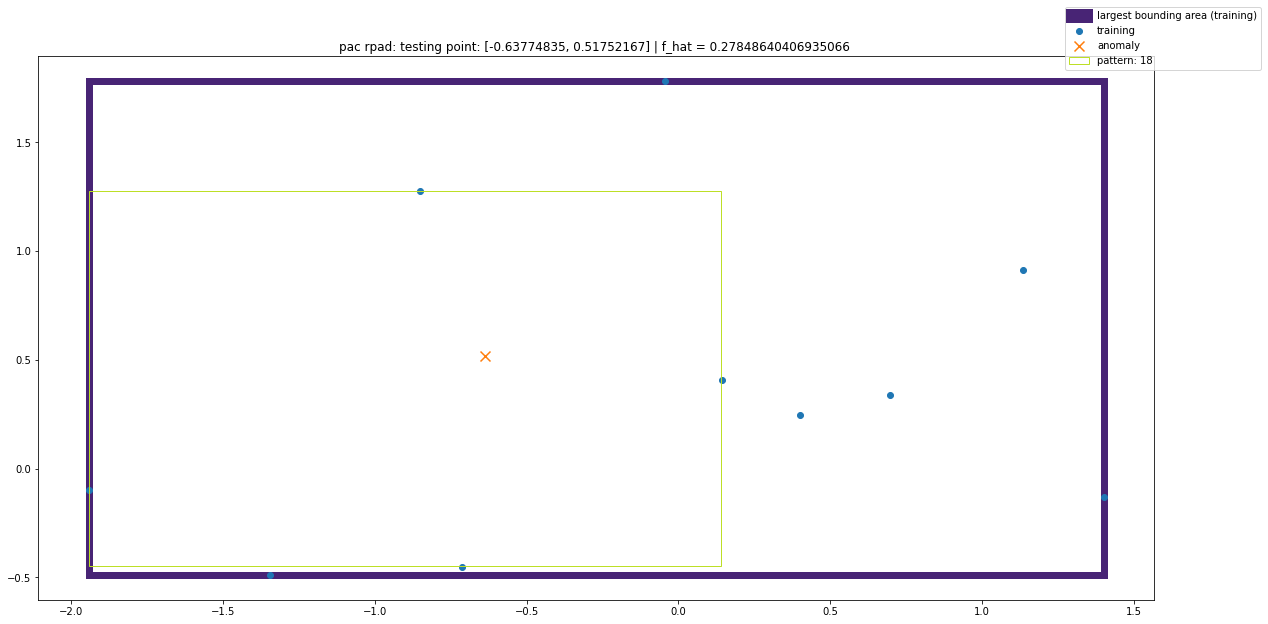

pattern:  [[-0.71023401  1.40074111]
 [-1.94093729  0.24309925]]


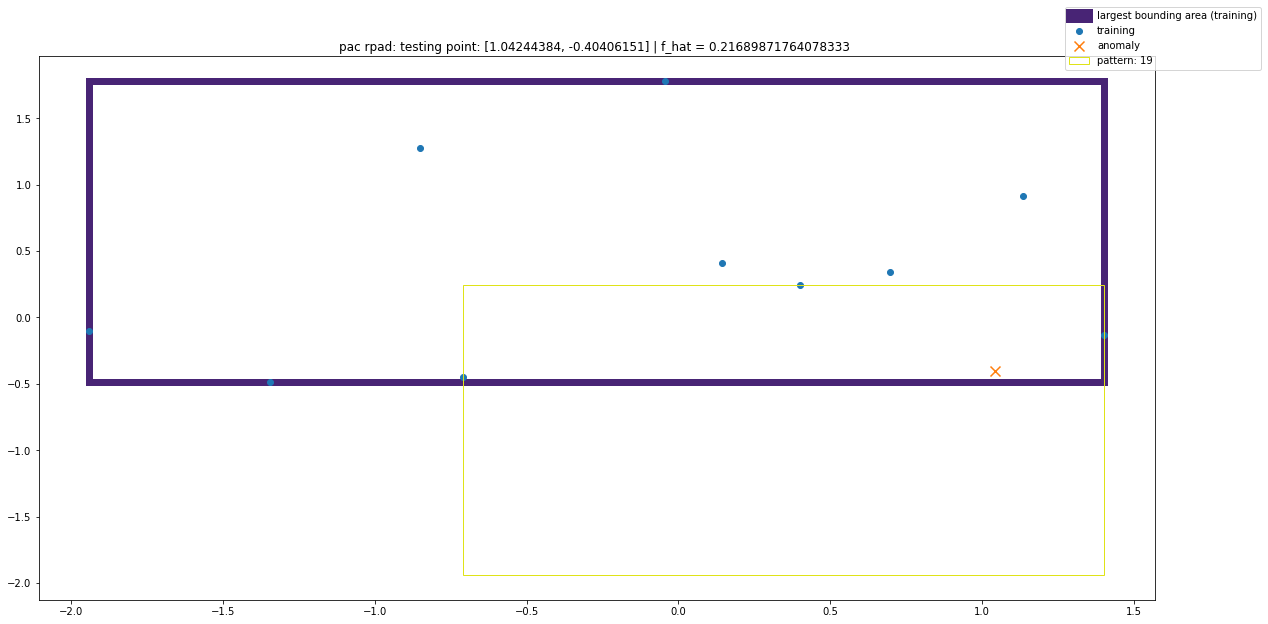

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,10)
cmap = plt.get_cmap('viridis')


def draw_largest_bounding_area(interval, ax):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(0.1),
        label= "largest bounding area (training)",
        linewidth=7.0
        )
    )


total = len(testing_points)
for i, (k,v) in enumerate(exact.find_min_f_hat.items()):
    ax = plt.gca()
    k = [float(x) for x in k[1:-1].split(" ") if x]
    point = k # exact.testing_points[i]
    draw_largest_bounding_area(exact.solver.largest_bounding_area.T, ax)
    ax.scatter(x=exact.training_points[:,0], y=exact.training_points[:,1], marker="o", label="training")
    pattern = np.array(v['pattern'])
    anomaly = v['anomaly']
    f_hat = v['objective']
    if anomaly:
        plt.scatter(x=k[0], y=k[1], marker="x", s=100, label="anomaly")
        print("pattern: ", pattern)
        if pattern.all() != None:
            draw2dpattern(pattern, ax, i, total)
    else:
        draw2dpattern(pattern, ax, i, total)
        ax.scatter(x=point[0], y=point[1], marker="x", s=150, label=f"testing point: {k}: normal")
    ax.legend(bbox_to_anchor=(1.1, 1.1))
    plt.title(f"pac rpad: testing point: {k} | f_hat = {f_hat} ")
    plt.show()


In [ ]:
# TODO: TEST !!!
    # - implemenent simple test (4 points where the correct answer is already known)
    #   - find the correct pattern, respect the boundaries in each of the dim, use simplest training set and simplest test point 
    #   - training set: (0.0,0.0) (2.0,0.0) (0.0,2.0) (2.0,2.0)
    #   - testing point: (1.0,1.0) 
    #   - unit test to test the functionnalities of the functions 
        # run solver and compare with the expected result 
            # - for the pattern intervals 
            # - for the min area 
            # - for the largest_bounding_area
    
# - one important thing is to think about how to configure the min_area value depending on the dataset.
    # min area: fraction of the bounding area, makes it dependent on the number of training points!  